Practical Work: Out-of-Distribution Detection, OOD Scoring Methods, and Neural Collapse.

# 1. Training a ResNet18 classifier on CIFAR-100 with PyTorch

In [29]:
import torch
import torchvision
from torchvision.models import resnet18
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA


In [30]:
# Hyperparameters (Improved to reduce overfitting)
batch_size = 64
num_workers = 12
lr = 5e-2
momentum = 0.9
weight_decay = 1e-3
epochs = 300  # Increased from 100
dropout = 0.3
# Skip training and load model locally.
# If never trained, set to False to train and save the model first.
skip_training = True # True to skip

# Random seed
torch.manual_seed(42)


In [31]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # Initial convolution adapted for CIFAR-100 (3x3 kernel instead of 7x7, stride 1)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Note: No maxpooling layer here for CIFAR to preserve spatial dimensions
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.linear = nn.Linear(512 * block.expansion, num_classes)
        
        # Rename linear to fc to match previous code usage if needed
        self.fc = self.linear

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18_Custom(num_classes=100):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [32]:

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    transforms.RandomErasing(p=0.3),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])


# Load CIFAR-100
train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Non-augmented training set for NECO evaluation
train_set_eval = torchvision.datasets.CIFAR100(root='./data', train=True, download=False, transform=transform_test)
train_loader_eval = torch.utils.data.DataLoader(train_set_eval, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# train_loader_eval = train_loader


# Model configuration
model = resnet18(False)
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) # For CIFAR-100, replace the first conv layer
model.maxpool = torch.nn.Identity()
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(dropout),
    torch.nn.Linear(512, 100)
)
# model = ResNet18_Custom(num_classes=100)
model = model.cuda()

# Optim, Loss, Scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1) 

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Training loop
def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Simple Test Loop
def test(epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

Using device: cuda


/users/eleves-b/2024/huanshan.huang/miniconda3/envs/inf554/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")
/users/eleves-b/2024/huanshan.huang/miniconda3/envs/inf554/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/users/eleves-b/2024/huanshan.huang/miniconda3/envs/inf554/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


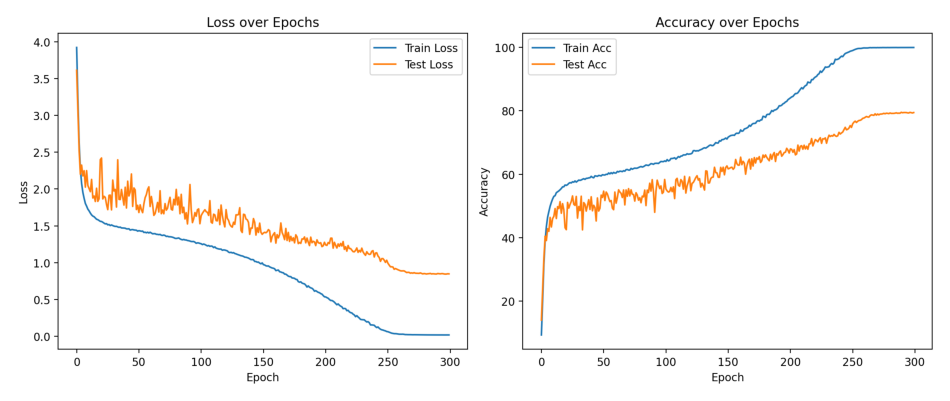

In [33]:
# Load model
if skip_training:  # Change to True to load the model
    try:
        model.load_state_dict(torch.load('resnet18_cifar100.pth', map_location=device))
        plot_path = "training_curves.png"
        img = plt.imread(plot_path)
        plt.figure(figsize=(12, 5))
        plt.imshow(img)
        plt.axis("off")
        plt.show()
    except FileNotFoundError:
        assert False, "Model or training curves not found. Please train the model first."
else:
    # Main training and testing loop
    for epoch in range(epochs):
        train_loss, train_acc = train(epoch)
        test_loss, test_acc = test(epoch)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        scheduler.step()

    # Save model
    torch.save(model.state_dict(), 'resnet18_cifar100.pth')

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_curves.png", dpi=200, bbox_inches="tight")
    plt.show()


# 2. Implement and compare OOD scores
Implement and compare the following OOD scores:

· Max Softmax Probability (MSP)

· Maximum Logit Score

· Mahalanobis

· Energy Score

· ViM

## 2.1 Max Softmax Probability (MSP). 
If the classifier assigns low maximum probability, it is unsure or the input may be OOD.

Score: the maximum softmax probability
$$s_{max-prob}(x)=\mathop{max}\limits_{c} p(y=c|x)=\mathop{max}\limits_{c} softmax(z_c(x))$$

In [34]:
def msp_score(model, loader):
    model.eval()
    all_scores = []

    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            logits = model(inputs)
            probs = F.softmax(logits, dim=1)

            max_probs, _ = torch.max(probs, dim=1)
            
            all_scores.append(max_probs.cpu())
            
    return torch.cat(all_scores)

msp_scores = msp_score(model, test_loader)

print(f"MSP scores: {msp_scores}")

MSP scores: tensor([0.0585, 0.3177, 0.2352,  ..., 0.7527, 0.8783, 0.6779])


## 3. Max Logit technique. 
Logits reflect raw model evidence before the softmax normalization; using logits avoids saturating effects of softmax.
$$s_{max-logit}(x)= \mathop{max}\limits_{c}\ z_c(x)$$

In [35]:
def max_logit_score(model, loader):
    model.eval()
    all_scores = []
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            logits = model(inputs)
            max_logits, _ = torch.max(logits, dim=1)
            all_scores.append(max_logits.cpu())
    return torch.cat(all_scores)

max_logit_scores = max_logit_score(model, test_loader)
print(f"Max logit scores: {max_logit_scores}")

Max logit scores: tensor([1.9480, 3.9701, 3.6897,  ..., 5.8255, 6.5887, 5.7333])


## 4. Energy-based OOD score.

Energy provides a scalar that correlates with the model’s
total evidence across classes. Lower energy (more negative) implies
stronger evidence; higher energy (less negative or positive) can
indicate OOD. Energy score derived from the logits: a common definition:

$$  E(x) = -log(\sum_{c}{ }e^{z_c(x)}) = -LSE(z(x))$$

With temperature $T>0$ one can use:
$$ E_T(x) = -T*log(\sum_{c}{ }e^{z_c(x)/T})$$

In [36]:
def energy_score(model, loader, Temperature=1):
    model.eval()
    all_scores = []
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            logits = model(inputs)
            if Temperature <= 0:
                raise ValueError("Temperature must be greater than 0.")
            energy = Temperature * torch.logsumexp(logits / Temperature, dim=1)
            all_scores.append(energy.cpu())
    return torch.cat(all_scores)

energy_scores = energy_score(model, test_loader, Temperature=1)
print(f"Energy scores: {energy_scores}")

Energy scores: tensor([4.7869, 5.1168, 5.1370,  ..., 6.1096, 6.7185, 6.1221])


## 5. Mahalanobis Distance-based OOD Detection

For each class $c$, compute the class mean in feature space:
$$ \mu _c = 1/N_c \sum_{i:y_i=c}{}{f(x_i)} $$

Then, estimate a shared covariance matrix $\Sigma$ (or per-class covariance), typically eh empirical covariance of features across the training set.

Therefore, the Mahalanobis score calculated as:
$$ d_{ M a h a } ( x ) = \operatorname* { m i n } _ { c } \, ( f ( x ) - \mu _ { c } ) ^ { \top } \Sigma ^ { - 1 } ( f ( x ) - \mu _ { c } ) $$

For each test sample, calculate the distance to all 100 class centers and take the minimum distance as the OOD score (the smaller the distance, the more similar to an in-distribution sample).

In [37]:
features_buffer = []

def hook_fn(module, input, output):
    # output shape [batch, 512, 1, 1]
    features_buffer.append(output.view(output.size(0), -1)) #flatten to [batch, 512]

# General hook registrationorks, works for ResNet18/34/50/101
handle = model.avgpool.register_forward_hook(hook_fn)

def extract_features(model, inputs):
    features_buffer.clear() 
    _ = model(inputs)       
    return features_buffer[0] 

def mahalanobis_score(model, train_loader, test_loader, num_classes=100):
    model.eval()

    train_features = []
    train_labels = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            features = extract_features(model, inputs)
            train_features.append(features.cpu())
            train_labels.append(labels)
    
    train_features = torch.cat(train_features)
    train_labels = torch.cat(train_labels)

    class_means = []
    for c in range(num_classes):
        class_features = train_features[train_labels == c]
        class_mean = torch.mean(class_features, dim=0)
        class_means.append(class_mean)
    class_means = torch.stack(class_means)  # shape: [100, feature_dim]

    cov = torch.cov(train_features.T) + 0.01 * torch.eye(train_features.size(1))
    inv_cov = torch.inverse(cov)
    all_scores = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            features = extract_features(model, inputs).cpu()
            batch_scores = []
            for feat in features:
                # Compute Mahalanobis distance to each class
                dists = []
                for class_mean in class_means:
                    diff = feat - class_mean
                    dist = diff @ inv_cov @ diff
                    dists.append(dist.item())
                min_dist = min(dists)
                batch_scores.append(-min_dist)
            
            all_scores.append(torch.tensor(batch_scores))

    return torch.cat(all_scores)

mahalanobis_scores = mahalanobis_score(model, train_loader, test_loader)
print(f"Mahalanobis scores: {mahalanobis_scores}")

# Cleanup hook
if 'handle' in globals():
    handle.remove()
    features_buffer.clear()

Mahalanobis scores: tensor([-122.3314, -161.2144, -103.8853,  ..., -583.5576, -149.8026,
         -89.0159])


## 6. ViM (Virtual-logit Matching) Score

This method combines the class-agnostic score from feature space and the In-Distribution (ID) class-dependent logits. 

$$s_{ViM}(x) = \alpha \cdot ||P_{residual}(f(x)-\mu)||_{2} - \log \sum_{c=1}^C e^{z_c(x)},$$

where

$$\alpha = \frac{\sum_{i} \max_c z_{c}(x_i)}{\sum_{i} ||x_i^\perp||_2}$$


In [38]:
import torch

features_buffer = []

def hook_fn(module, input, output):
    features_buffer.append(output.view(output.size(0), -1))

handle = model.avgpool.register_forward_hook(hook_fn)

def extract_features_and_logits(model, inputs):
    features_buffer.clear() 
    logits = model(inputs)
    features = features_buffer[0]
    return features, logits

def vim_score(model, train_loader, test_loader, num_principal_components=100, device='cuda'):
    model.eval()
    train_features = []
    train_logits = []

    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            features, logits = extract_features_and_logits(model, inputs)
            train_features.append(features.cpu())
            train_logits.append(logits.cpu())
            
    train_features = torch.cat(train_features)
    train_logits = torch.cat(train_logits)
    mean = torch.mean(train_features, dim=0)
    centered_features = train_features - mean
    
    # PCA
    cov = torch.cov(centered_features.T)
    eigenvalues, eigenvectors = torch.linalg.eigh(cov)
    idx = torch.argsort(eigenvalues, descending=True)
    eigenvectors = eigenvectors[:, idx]
    residual_components = eigenvectors[:, num_principal_components:]
    residual_proj_train = centered_features @ residual_components
    residual_norm_train = torch.norm(residual_proj_train, dim=1)
    max_logits_train, _ = torch.max(train_logits, dim=1)
    
    # alpha = sum(max_logits) / sum(residual_norms)
    alpha = max_logits_train.sum() / residual_norm_train.sum()

    all_scores = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            features, logits = extract_features_and_logits(model, inputs)
            features = features.cpu()
            logits = logits.cpu()
            
            # Geometric component
            centered = features - mean
            residual_proj = centered @ residual_components
            residual_norm = torch.norm(residual_proj, dim=1)
            
            # Semantic component
            lse = torch.logsumexp(logits, dim=1)

            vim_scores = alpha * residual_norm - lse
            
            all_scores.append(vim_scores)
            
    return torch.cat(all_scores)

vim_scores = vim_score(model, train_loader, test_loader, num_principal_components=100, device='cuda')
print(f"ViM scores: {vim_scores}")

if 'handle' in globals():
    handle.remove()
    features_buffer.clear()

ViM scores: tensor([-0.7023,  1.4033, -0.9632,  ...,  7.7080,  0.6254, -1.6994])


# 3. Study the Neural Collapse phenomenon at the end of training NC1 to NC4. 

## NC1: variability collapse: at the end of training, the in-class variation collapses to very low, due to the feature of each class converges to the mean of the class.

In [39]:
import numpy as np
from sklearn.manifold import TSNE

#Extract penultimate layer features
def extract_features(model, data_loader, device='cuda'):
    model.eval()
    features_list = []
    labels_list = []
    
    def hook_fn(module, input, output):
        features_list.append(output.view(output.size(0), -1).detach().cpu())
    
    hook_handle = model.avgpool.register_forward_hook(hook_fn)
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            _ = model(images)
            labels_list.append(targets.cpu())
    
    hook_handle.remove()
    
    features = torch.cat(features_list, dim=0).numpy()
    labels = torch.cat(labels_list, dim=0).numpy()
    
    return features, labels

#Extract training features
print("Extracting training features...")
train_features, train_labels = extract_features(model, train_loader, device='cuda')
print(f"Features shape: {train_features.shape}")
print(f"Labels shape: {train_labels.shape}")

#Compute class means and within-class variances
num_classes = 100
class_means = np.zeros((num_classes, train_features.shape[1]))
class_variances = []

for class_id in range(num_classes):
    class_mask = (train_labels == class_id)
    class_features = train_features[class_mask]
    
    class_mean = np.mean(class_features, axis=0)
    class_means[class_id] = class_mean
    
    variance = np.mean(np.var(class_features, axis=0))
    class_variances.append(variance)

print(f"Class means shape: {class_means.shape}")
print(f"Variances computed for {len(class_variances)} classes")


Extracting training features...
Features shape: (50000, 512)
Labels shape: (50000,)
Class means shape: (100, 512)
Variances computed for 100 classes


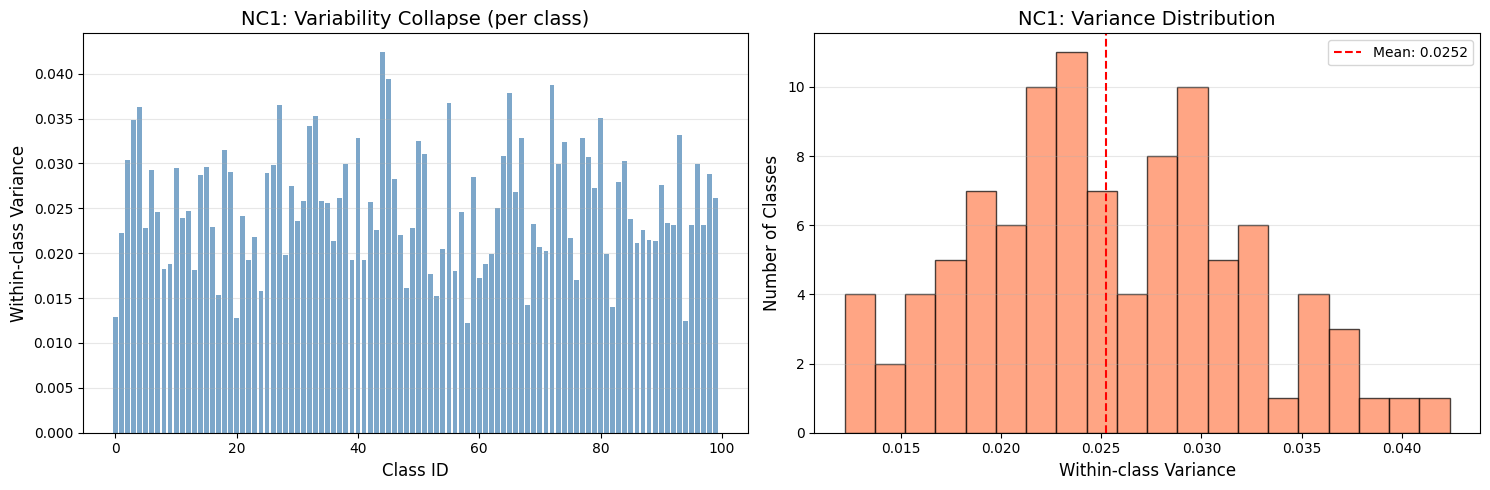


=== Expected NC1 Criteria ===
Mean variance: < 0.01 (the smaller the better, close to zero)
Std variance: < 0.005 (low variance across classes)
Max variance: < 0.05 (even worst class should collapse)
Min variance: < 0.005 (best class nearly perfect)

=== My NC1 Statistics ===
Mean variance: 0.025220
Std variance: 0.006683
Max variance: 0.042378
Min variance: 0.012211

Performing t-SNE dimensionality reduction...


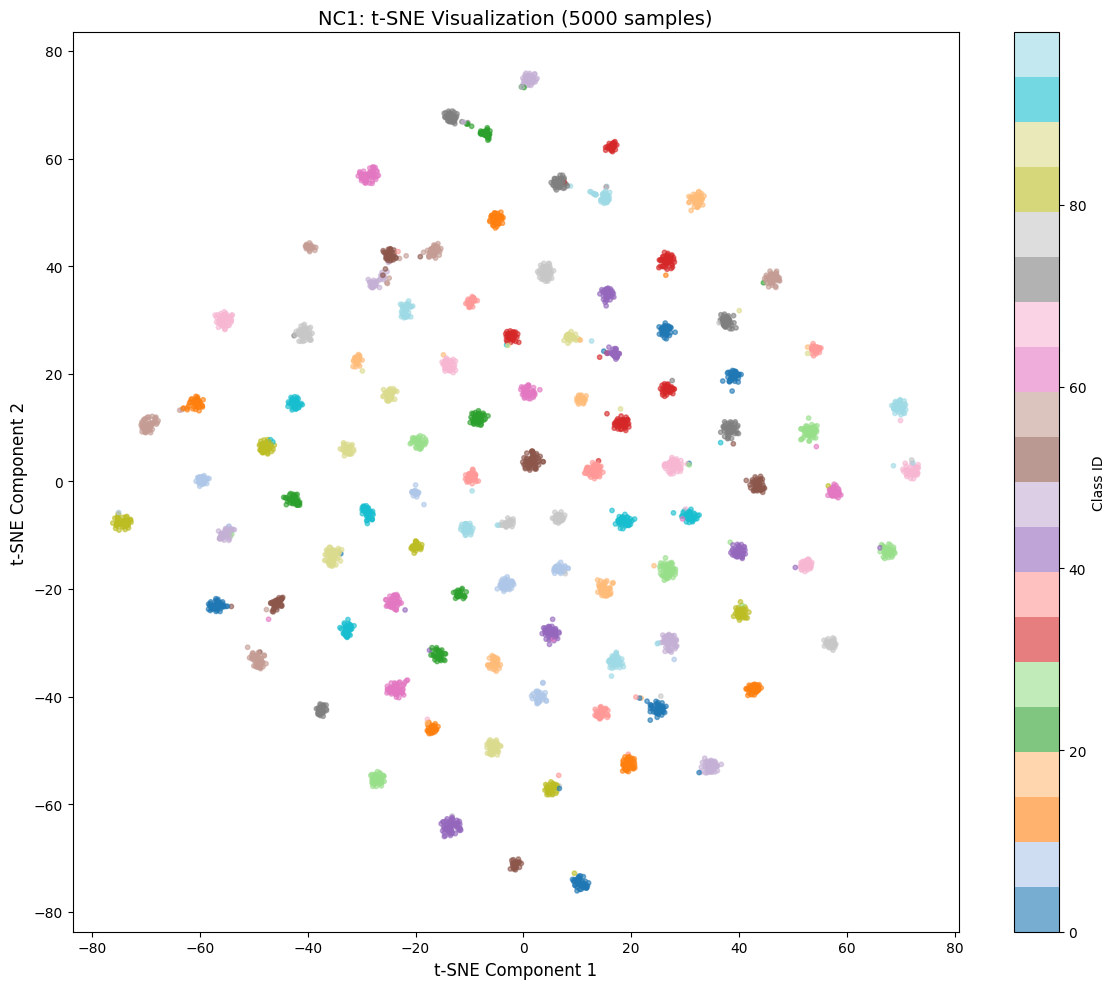

In [40]:
#Visualize NC1 - Variability Collapse

# Plot 1: Per-class variance bar chart
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(range(num_classes), class_variances, color='steelblue', alpha=0.7)
plt.xlabel('Class ID', fontsize=12)
plt.ylabel('Within-class Variance', fontsize=12)
plt.title('NC1: Variability Collapse (per class)', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Plot 2: Variance distribution histogram
plt.subplot(1, 2, 2)
plt.hist(class_variances, bins=20, color='coral', alpha=0.7, edgecolor='black')
plt.xlabel('Within-class Variance', fontsize=12)
plt.ylabel('Number of Classes', fontsize=12)
plt.title('NC1: Variance Distribution', fontsize=14)
plt.axvline(np.mean(class_variances), color='red', linestyle='--', 
            label=f'Mean: {np.mean(class_variances):.4f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('NC1_variance.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print("\n=== Expected NC1 Criteria ===")
print("Mean variance: < 0.01 (the smaller the better, close to zero)")
print("Std variance: < 0.005 (low variance across classes)")
print("Max variance: < 0.05 (even worst class should collapse)")
print("Min variance: < 0.005 (best class nearly perfect)")

print("\n=== My NC1 Statistics ===")
print(f"Mean variance: {np.mean(class_variances):.6f}")
print(f"Std variance: {np.std(class_variances):.6f}")
print(f"Max variance: {np.max(class_variances):.6f}")
print(f"Min variance: {np.min(class_variances):.6f}")

#  t-SNE visualization
print("\nPerforming t-SNE dimensionality reduction...")

sample_size = 5000
sample_indices = np.random.choice(len(train_features), sample_size, replace=False)
features_sample = train_features[sample_indices]
labels_sample = train_labels[sample_indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features_sample)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                     c=labels_sample, cmap='tab20', 
                     s=10, alpha=0.6)
plt.colorbar(scatter, label='Class ID')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('NC1: t-SNE Visualization (5000 samples)', fontsize=14)
plt.tight_layout()
plt.savefig('NC1_tsne.png', dpi=150, bbox_inches='tight')
plt.show()


## NC2: convergence to Simplex Equiangular Tight Frame(ETF): the mean centers of different classes form an ETF structure, meaning they are equidistant from each other in the feature space while maximizing angular separation.

### PS: Here I found out the result notcorresponding for NC3-4 and I found out missed centering the data I provide the wrong version here too

In [41]:
## NC2: Simplex ETF Structure

# Initial Attempt (Non-Centered - INCORRECT)
#Note: This version forgot the centering step, leading to positive correlations
from scipy.spatial.distance import cosine

num_classes = class_means.shape[0]
cosine_similarities = np.zeros((num_classes, num_classes))

for i in range(num_classes):
    for j in range(num_classes):
        if i != j:
            # Cosine similarity = dot product of normalized vectors
            cos_sim = np.dot(class_means[i], class_means[j]) / \
                     (np.linalg.norm(class_means[i]) * np.linalg.norm(class_means[j]))
            cosine_similarities[i, j] = cos_sim
        else:
            cosine_similarities[i, j] = 1.0  # Self-similarity is 1

# Extract upper triangle (unique pairs)
upper_triangle_indices = np.triu_indices(num_classes, k=1)
pairwise_cos_sim = cosine_similarities[upper_triangle_indices]

# Convert cosine similarities to angles (in degrees)
pairwise_angles = np.arccos(np.clip(pairwise_cos_sim, -1, 1)) * 180 / np.pi

# Theoretical ETF value for cosine similarity
theoretical_cos_sim = -1 / (num_classes - 1)
theoretical_angle = np.arccos(theoretical_cos_sim) * 180 / np.pi

print("\n=== My NC2 Statistics ===")
print(f"Computed {len(pairwise_cos_sim)} unique pairwise similarities")
print(f"Theoretical ETF cosine similarity: {theoretical_cos_sim:.6f}")
print(f"Theoretical ETF angle: {theoretical_angle:.2f} degrees")



=== My NC2 Statistics ===
Computed 4950 unique pairwise similarities
Theoretical ETF cosine similarity: -0.010101
Theoretical ETF angle: 90.58 degrees


In [42]:
# NC2 CORRECTED (with centering)

print("\n=== NC2 CORRECTED VERSION (with centering) ===")

# # CRITICAL FIX: Center class means relative to global mean
global_mean = np.mean(class_means, axis=0)
centered_class_means = class_means - global_mean

# centered_class_means = class_means

print(f"Global mean norm: {np.linalg.norm(global_mean):.4f}")
print(f"Centered verification (should be ~0): {np.linalg.norm(np.mean(centered_class_means, axis=0)):.6f}")

# Compute pairwise cosine similarities on CENTERED data
num_classes = centered_class_means.shape[0]
cosine_similarities = np.zeros((num_classes, num_classes))

print("Computing CENTERED pairwise cosine similarities...")
for i in range(num_classes):
    for j in range(num_classes):
        if i != j:
            cos_sim = np.dot(centered_class_means[i], centered_class_means[j]) / \
                     (np.linalg.norm(centered_class_means[i]) * np.linalg.norm(centered_class_means[j]))
            cosine_similarities[i, j] = cos_sim
        else:
            cosine_similarities[i, j] = 1.0

# Extract unique pairs
upper_triangle_indices = np.triu_indices(num_classes, k=1)
pairwise_cos_sim = cosine_similarities[upper_triangle_indices]
pairwise_angles = np.arccos(np.clip(pairwise_cos_sim, -1, 1)) * 180 / np.pi

# Theoretical ETF
theoretical_cos_sim = -1 / (num_classes - 1)
theoretical_angle = np.arccos(theoretical_cos_sim) * 180 / np.pi

print(f"Computed {len(pairwise_cos_sim)} unique pairwise similarities")
print(f"Theoretical ETF cosine similarity: {theoretical_cos_sim:.6f}")
print(f"Theoretical ETF angle: {theoretical_angle:.2f} degrees")


=== NC2 CORRECTED VERSION (with centering) ===
Global mean norm: 5.8193
Centered verification (should be ~0): 0.000000
Computing CENTERED pairwise cosine similarities...
Computed 4950 unique pairwise similarities
Theoretical ETF cosine similarity: -0.010101
Theoretical ETF angle: 90.58 degrees


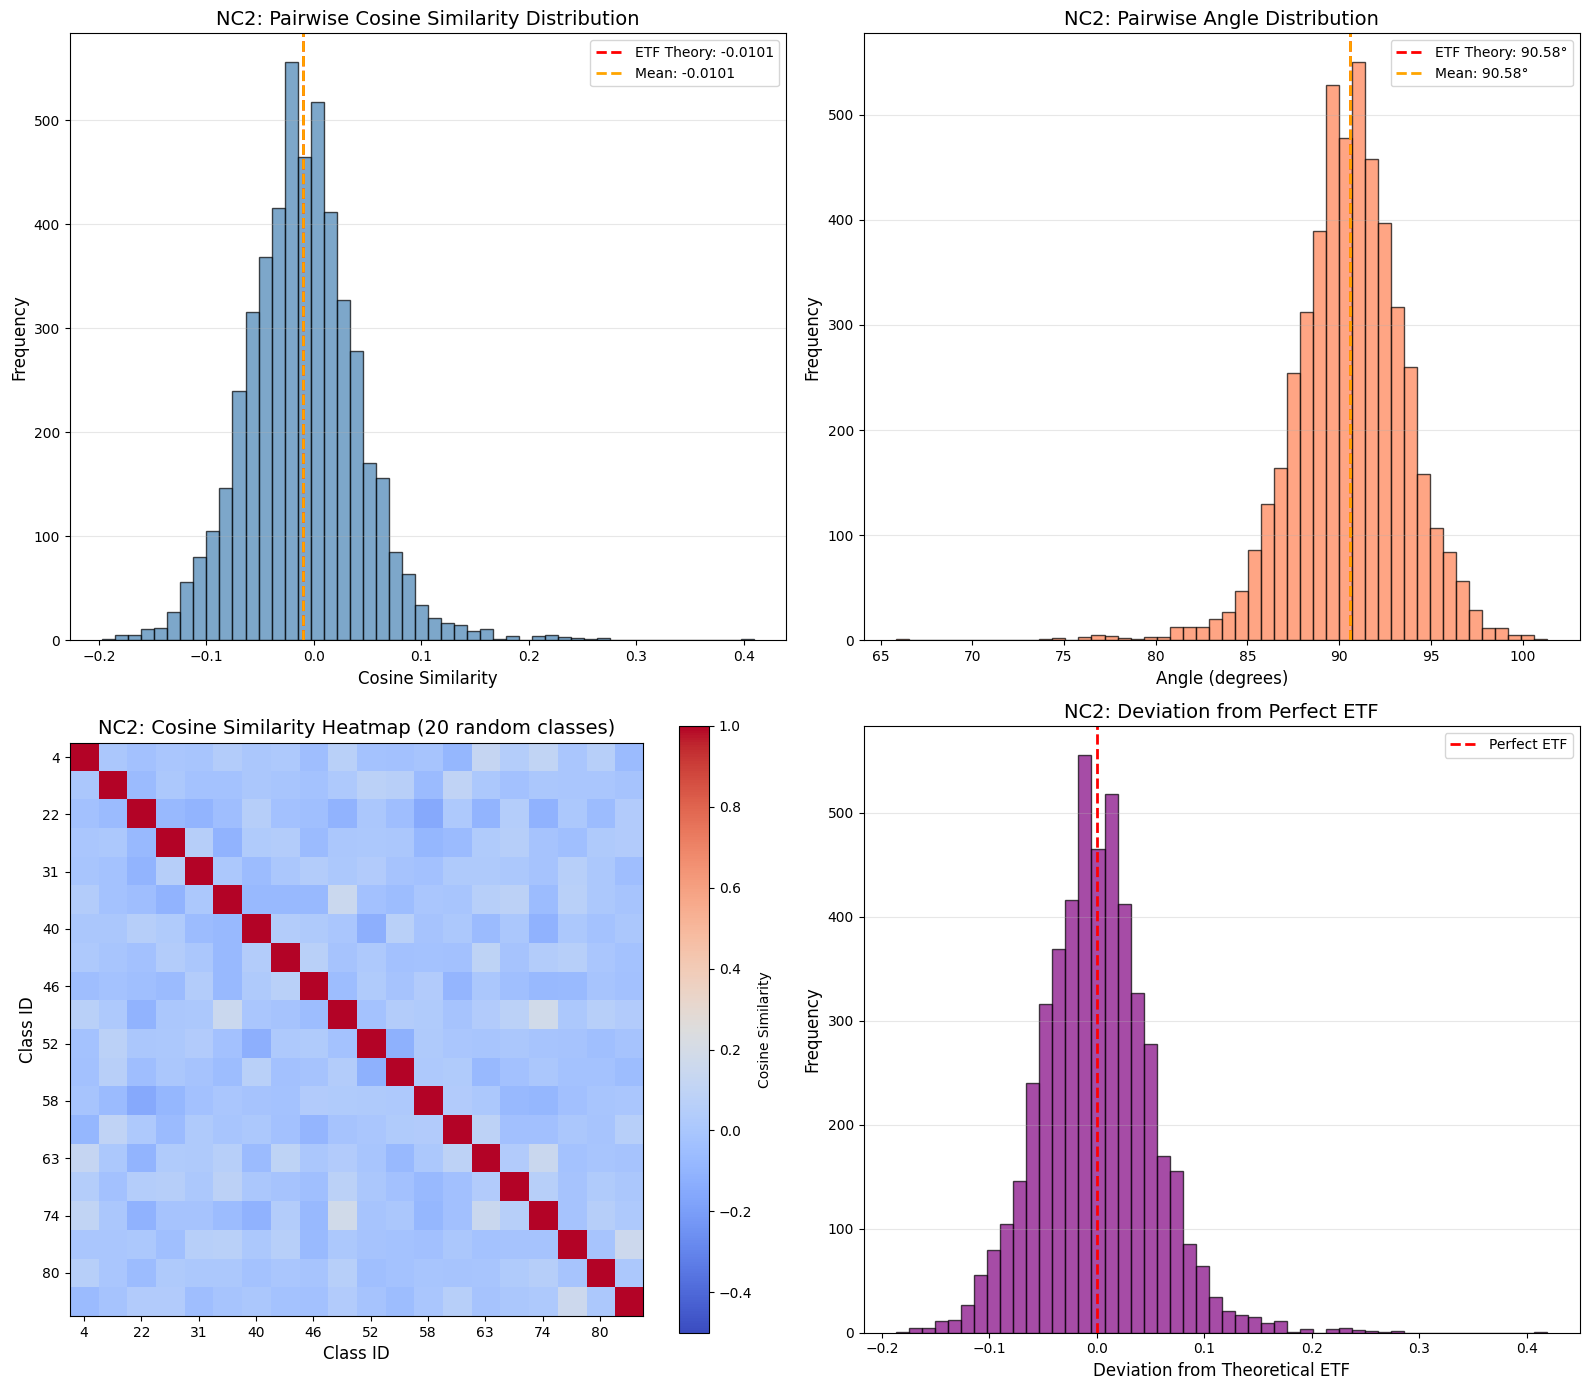


=== Expected NC2 Criteria ===
Theoretical cosine similarity: -0.010101
Theoretical angle: 90.58 degrees
Deviation std should be < 0.05 for strong NC2

=== My NC2 Statistics ===
Mean cosine similarity: -0.010092
Std cosine similarity: 0.052665
Mean angle: 90.58 degrees
Std angle: 3.02 degrees
Mean deviation from ETF: 0.000009
Std deviation from ETF: 0.052665

=== NC2 Assessment ===
Weak NC2: Some ETF structure but significant deviation

Status: Std deviation (0.0527) from theoretical ETF


In [43]:
# NC2 Visualization ( right and wrong version can share this to plot)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Cosine similarity distribution
axes[0, 0].hist(pairwise_cos_sim, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(theoretical_cos_sim, color='red', linestyle='--', linewidth=2,
                   label=f'ETF Theory: {theoretical_cos_sim:.4f}')
axes[0, 0].axvline(np.mean(pairwise_cos_sim), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(pairwise_cos_sim):.4f}')
axes[0, 0].set_xlabel('Cosine Similarity', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('NC2: Pairwise Cosine Similarity Distribution', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Angle distribution
axes[0, 1].hist(pairwise_angles, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(theoretical_angle, color='red', linestyle='--', linewidth=2,
                   label=f'ETF Theory: {theoretical_angle:.2f}°')
axes[0, 1].axvline(np.mean(pairwise_angles), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(pairwise_angles):.2f}°')
axes[0, 1].set_xlabel('Angle (degrees)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('NC2: Pairwise Angle Distribution', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Cosine similarity heatmap (for 20 random classes)
sample_classes = np.random.choice(num_classes, 20, replace=False)
sample_classes = np.sort(sample_classes)
cos_sim_sample = cosine_similarities[np.ix_(sample_classes, sample_classes)]

im = axes[1, 0].imshow(cos_sim_sample, cmap='coolwarm', vmin=-0.5, vmax=1.0)
axes[1, 0].set_xlabel('Class ID', fontsize=12)
axes[1, 0].set_ylabel('Class ID', fontsize=12)
axes[1, 0].set_title('NC2: Cosine Similarity Heatmap (20 random classes)', fontsize=14)
axes[1, 0].set_xticks(range(0, 20, 2))
axes[1, 0].set_xticklabels(sample_classes[::2])
axes[1, 0].set_yticks(range(0, 20, 2))
axes[1, 0].set_yticklabels(sample_classes[::2])
plt.colorbar(im, ax=axes[1, 0], label='Cosine Similarity')

# Plot 4: Deviation from ETF
deviation_from_etf = pairwise_cos_sim - theoretical_cos_sim
axes[1, 1].hist(deviation_from_etf, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect ETF')
axes[1, 1].set_xlabel('Deviation from Theoretical ETF', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('NC2: Deviation from Perfect ETF', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('NC2_etf_structure.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
print("\n=== Expected NC2 Criteria ===")
print(f"Theoretical cosine similarity: {theoretical_cos_sim:.6f}")
print(f"Theoretical angle: {theoretical_angle:.2f} degrees")
print("Deviation std should be < 0.05 for strong NC2")

print("\n=== My NC2 Statistics ===")
print(f"Mean cosine similarity: {np.mean(pairwise_cos_sim):.6f}")
print(f"Std cosine similarity: {np.std(pairwise_cos_sim):.6f}")
print(f"Mean angle: {np.mean(pairwise_angles):.2f} degrees")
print(f"Std angle: {np.std(pairwise_angles):.2f} degrees")
print(f"Mean deviation from ETF: {np.mean(deviation_from_etf):.6f}")
print(f"Std deviation from ETF: {np.std(deviation_from_etf):.6f}")

print("\n=== NC2 Assessment ===")
std_dev = np.std(deviation_from_etf)
if std_dev < 0.02:
    print("Strong NC2: Class means form near-perfect ETF structure")
elif std_dev < 0.05:
    print("Partial NC2: Moderate ETF structure with some variance")
elif std_dev < 0.10:
    print("Weak NC2: Some ETF structure but significant deviation")
else:
    print("No NC2: Class means do not form ETF structure")

print(f"\nStatus: Std deviation ({std_dev:.4f}) from theoretical ETF")


## NC3: convergence to self-duaality: the class means and linear classifiers converges to each other, up to rescaling.

In [44]:
final_layer = model.fc[-1]  # Get the Linear layer
classifier_weights = final_layer.weight.data.cpu().numpy()  # [100, 512]

print(f"Classifier weights shape: {classifier_weights.shape}")
print(f"Class means shape: {class_means.shape}")

# Compute correlations and angles for each class
num_classes = class_means.shape[0]
correlations = []
angles = []

for i in range(num_classes):
    mean_i = class_means[i]
    weight_i = classifier_weights[i]
    
    # Pearson correlation
    corr, _ = pearsonr(mean_i, weight_i)
    correlations.append(corr)
    
    # Angle between vectors
    cos_angle = np.dot(mean_i, weight_i) / (np.linalg.norm(mean_i) * np.linalg.norm(weight_i))
    angle = np.arccos(np.clip(cos_angle, -1, 1)) * 180 / np.pi
    angles.append(angle)

correlations = np.array(correlations)
angles = np.array(angles)

print(f"Computed {len(correlations)} class alignments")


Classifier weights shape: (100, 512)
Class means shape: (100, 512)
Computed 100 class alignments


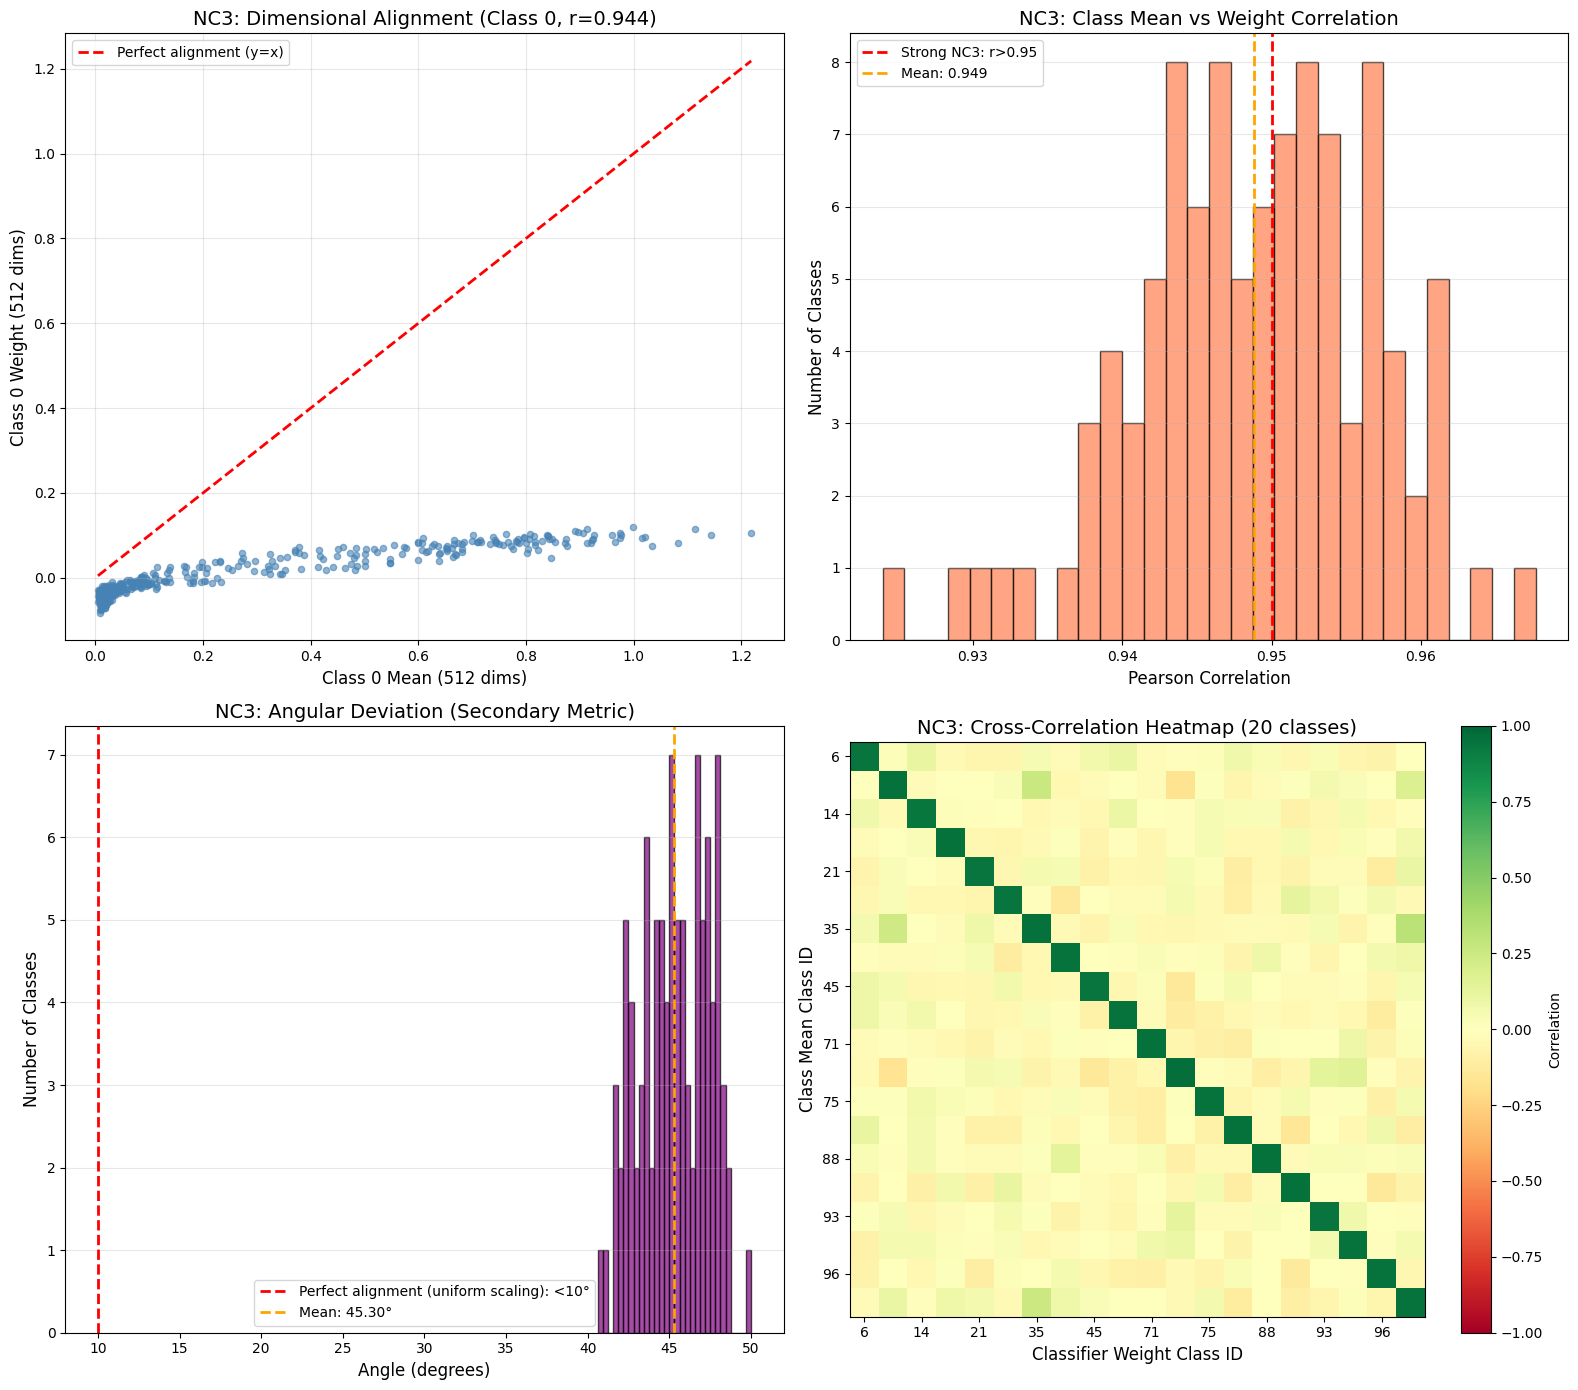


=== Expected NC3 Criteria ===
Mean correlation: > 0.95 for strong NC3
Mean angle: < 10 degrees for strong NC3
All classes should show high positive correlation

=== My NC3 Statistics ===
Mean correlation: 0.948857
Std correlation: 0.008027
Min correlation: 0.923951
Max correlation: 0.967686
Mean angle: 45.30 degrees
Std angle: 2.07 degrees

=== NC3 Assessment ===
Partial NC3: Moderate alignment between means and weights

Status: Mean correlation (0.949) indicates alignment strength
Classes with high alignment (>0.8): 100/100
Classes with poor alignment (<0.5): 0/100


In [45]:
# NC3 Visualization

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Scatter plot for one representative class
sample_class = 0
axes[0, 0].scatter(class_means[sample_class], classifier_weights[sample_class], 
                   s=20, alpha=0.6, color='steelblue')
axes[0, 0].plot([class_means[sample_class].min(), class_means[sample_class].max()],
                [class_means[sample_class].min(), class_means[sample_class].max()],
                'r--', linewidth=2, label='Perfect alignment (y=x)')
axes[0, 0].set_xlabel(f'Class {sample_class} Mean (512 dims)', fontsize=12)
axes[0, 0].set_ylabel(f'Class {sample_class} Weight (512 dims)', fontsize=12)
axes[0, 0].set_title(f'NC3: Dimensional Alignment (Class {sample_class}, r={correlations[sample_class]:.3f})', 
                     fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Correlation distribution across all classes
axes[0, 1].hist(correlations, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(0.95, color='red', linestyle='--', linewidth=2, label='Strong NC3: r>0.95')
axes[0, 1].axvline(np.mean(correlations), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(correlations):.3f}')
axes[0, 1].set_xlabel('Pearson Correlation', fontsize=12)
axes[0, 1].set_ylabel('Number of Classes', fontsize=12)
axes[0, 1].set_title('NC3: Class Mean vs Weight Correlation', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Angle distribution
axes[1, 0].hist(angles, bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(10, color='red', linestyle='--', linewidth=2, 
                   label='Perfect alignment (uniform scaling): <10°')
axes[1, 0].axvline(np.mean(angles), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(angles):.2f}°')
axes[1, 0].set_xlabel('Angle (degrees)', fontsize=12)
axes[1, 0].set_ylabel('Number of Classes', fontsize=12)
axes[1, 0].set_title('NC3: Angular Deviation (Secondary Metric)', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Heatmap of top correlations (20 classes sample)
sample_classes = np.random.choice(num_classes, 20, replace=False)
sample_classes = np.sort(sample_classes)
correlation_matrix = np.zeros((20, 20))

for idx_i, i in enumerate(sample_classes):
    for idx_j, j in enumerate(sample_classes):
        corr, _ = pearsonr(class_means[i], classifier_weights[j])
        correlation_matrix[idx_i, idx_j] = corr

im = axes[1, 1].imshow(correlation_matrix, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1, 1].set_xlabel('Classifier Weight Class ID', fontsize=12)
axes[1, 1].set_ylabel('Class Mean Class ID', fontsize=12)
axes[1, 1].set_title('NC3: Cross-Correlation Heatmap (20 classes)', fontsize=14)
axes[1, 1].set_xticks(range(0, 20, 2))
axes[1, 1].set_xticklabels(sample_classes[::2])
axes[1, 1].set_yticks(range(0, 20, 2))
axes[1, 1].set_yticklabels(sample_classes[::2])
plt.colorbar(im, ax=axes[1, 1], label='Correlation')

plt.tight_layout()
plt.savefig('NC3_self_duality.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
print("\n=== Expected NC3 Criteria ===")
print("Mean correlation: > 0.95 for strong NC3")
print("Mean angle: < 10 degrees for strong NC3")
print("All classes should show high positive correlation")

print("\n=== My NC3 Statistics ===")
print(f"Mean correlation: {np.mean(correlations):.6f}")
print(f"Std correlation: {np.std(correlations):.6f}")
print(f"Min correlation: {np.min(correlations):.6f}")
print(f"Max correlation: {np.max(correlations):.6f}")
print(f"Mean angle: {np.mean(angles):.2f} degrees")
print(f"Std angle: {np.std(angles):.2f} degrees")

print("\n=== NC3 Assessment ===")
mean_corr = np.mean(correlations)
if mean_corr > 0.95:
    print("Strong NC3: Class means and weights are highly aligned")
elif mean_corr > 0.7:
    print("Partial NC3: Moderate alignment between means and weights")
elif mean_corr > 0.5:
    print("Weak NC3: Some alignment but significant deviation")
else:
    print("No NC3: Class means and weights are not aligned")

print(f"\nStatus: Mean correlation ({mean_corr:.3f}) indicates alignment strength")
print(f"Classes with high alignment (>0.8): {np.sum(correlations > 0.8)}/100")
print(f"Classes with poor alignment (<0.5): {np.sum(correlations < 0.5)}/100")


## NC4: simplification to nearest-class center: the behavior of the classifier ultimately simplifies to classification based on the nearest class centers in the feature space.

In [46]:
# Extract test set features and predictions
def extract_test_predictions(model, test_loader, class_means, device='cuda'):
    model.eval()
    
    all_features = []
    all_labels = []
    all_model_preds = []
    all_nearest_preds = []
    
    # Hook for feature extraction
    features_buffer = []
    def hook_fn(module, input, output):
        features_buffer.append(output.view(output.size(0), -1).detach().cpu())
    
    hook_handle = model.avgpool.register_forward_hook(hook_fn)
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            
            # Get model predictions
            logits = model(images)
            model_preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            # Get features
            features = features_buffer[-1].numpy()
            
            # Compute nearest center predictions
            nearest_preds = []
            for feat in features:
                distances = np.linalg.norm(class_means - feat, axis=1)
                nearest_preds.append(np.argmin(distances))
            
            all_features.append(features)
            all_labels.append(labels.numpy())
            all_model_preds.append(model_preds)
            all_nearest_preds.append(np.array(nearest_preds))
            
            features_buffer.clear()
    
    hook_handle.remove()
    
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_model_preds = np.concatenate(all_model_preds, axis=0)
    all_nearest_preds = np.concatenate(all_nearest_preds, axis=0)
    
    return all_features, all_labels, all_model_preds, all_nearest_preds

print("Extracting test set predictions...")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_features, test_labels, model_preds, nearest_preds = extract_test_predictions(
    model, test_loader, class_means, device=device
)

print(f"Test samples: {len(test_labels)}")
print(f"Model predictions: {model_preds.shape}")
print(f"Nearest center predictions: {nearest_preds.shape}")

# Compute consistency per class
num_classes = 100
consistency_per_class = []
samples_per_class = []

for class_id in range(num_classes):
    class_mask = (test_labels == class_id)
    class_model_preds = model_preds[class_mask]
    class_nearest_preds = nearest_preds[class_mask]
    
    if len(class_model_preds) > 0:
        consistency = np.mean(class_model_preds == class_nearest_preds) * 100
        consistency_per_class.append(consistency)
        samples_per_class.append(len(class_model_preds))
    else:
        consistency_per_class.append(0)
        samples_per_class.append(0)

consistency_per_class = np.array(consistency_per_class)
overall_consistency = np.mean(model_preds == nearest_preds) * 100

print(f"Overall consistency: {overall_consistency:.2f}%")


Extracting test set predictions...
Test samples: 10000
Model predictions: (10000,)
Nearest center predictions: (10000,)
Overall consistency: 97.63%


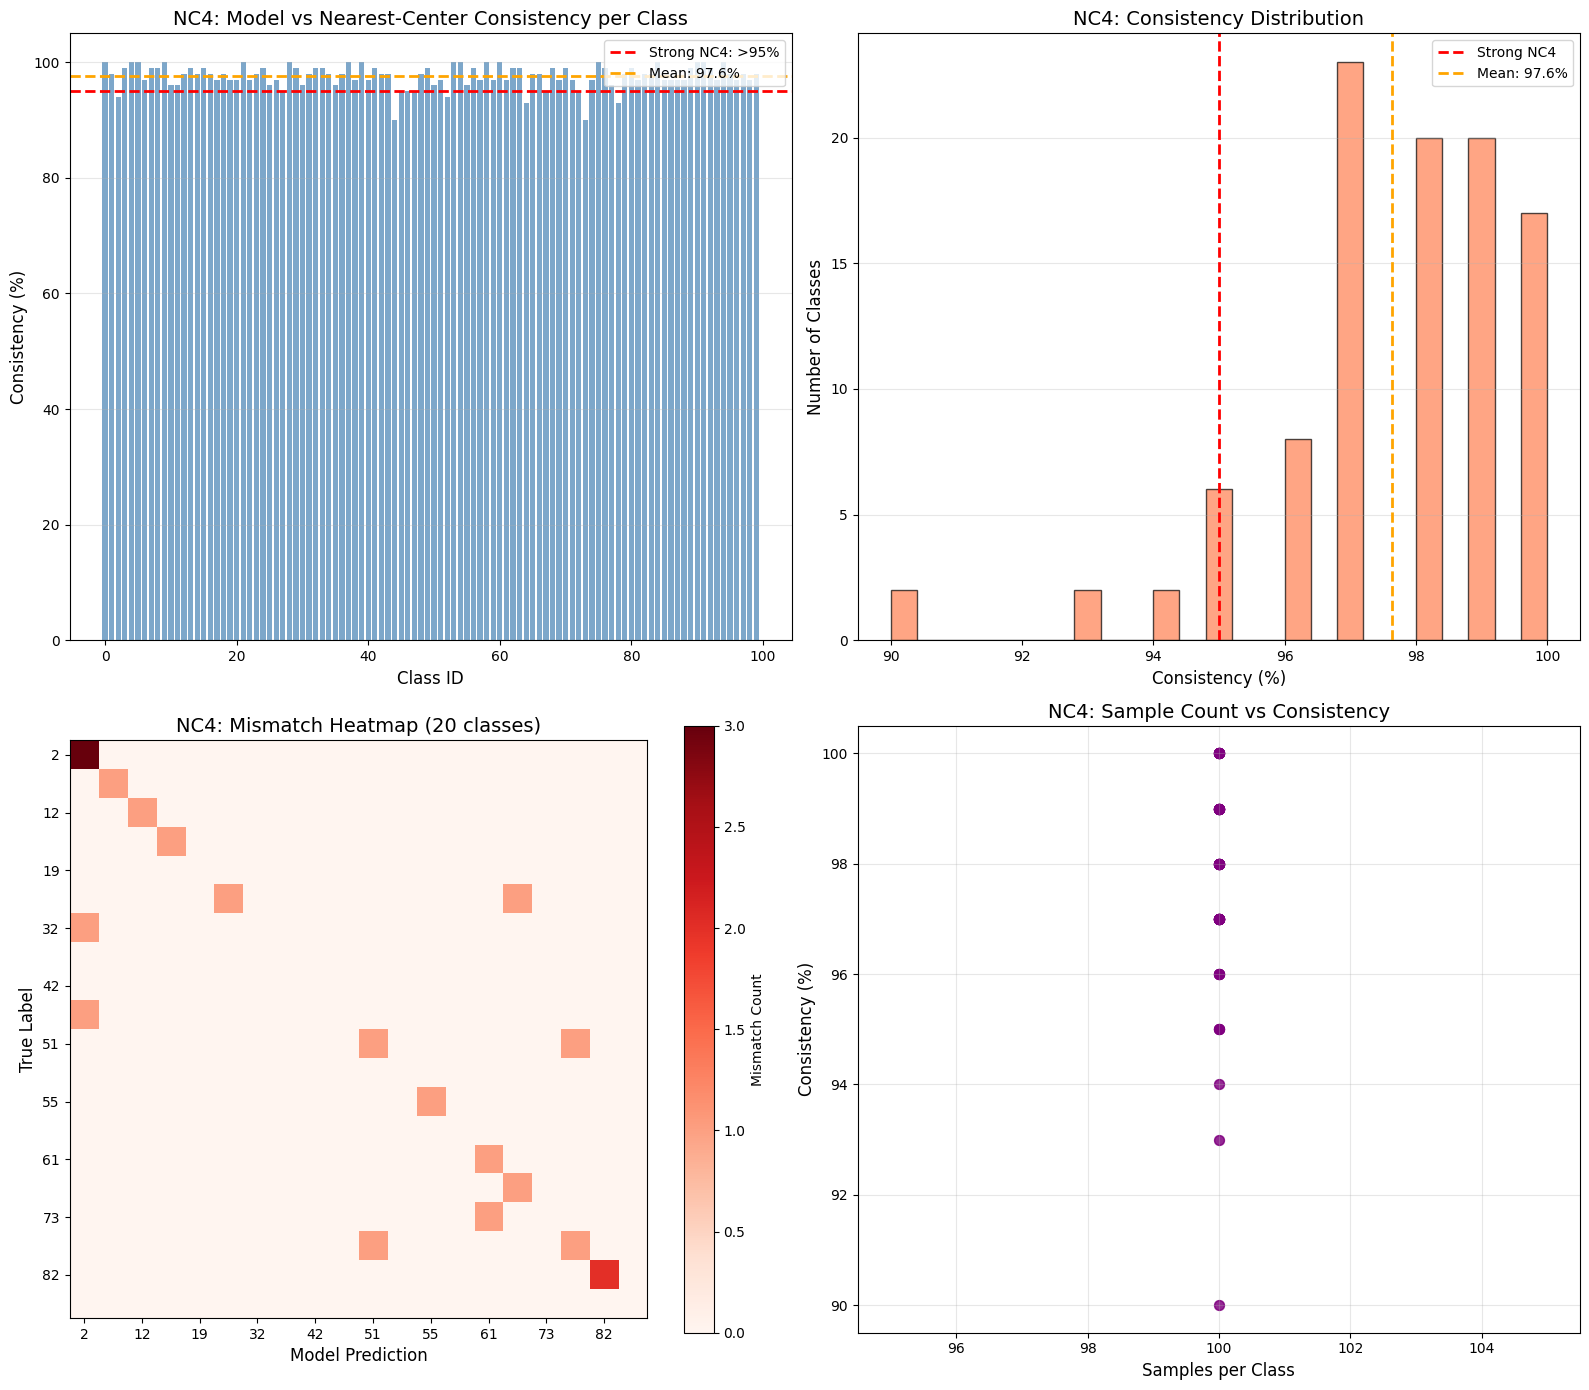


=== Expected NC4 Criteria ===
Overall consistency: > 95% for strong NC4
Most classes: > 90% consistency
Model decisions match nearest-center decisions

=== My NC4 Statistics ===
Overall consistency: 97.63%
Mean per-class consistency: 97.63%
Std per-class consistency: 1.98%
Min consistency: 90.00%
Max consistency: 100.00%
Classes with >90% consistency: 98/100
Classes with >80% consistency: 100/100
Classes with <70% consistency: 0/100

=== NC4 Assessment ===
[Strong NC4] Model predictions strongly align with nearest-center decisions

Status: 97.6% of predictions match nearest class center
This indicates strong NC4 behavior


In [47]:
# NC4 Visualization

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Consistency per class
axes[0, 0].bar(range(num_classes), consistency_per_class, color='steelblue', alpha=0.7)
axes[0, 0].axhline(95, color='red', linestyle='--', linewidth=2, label='Strong NC4: >95%')
axes[0, 0].axhline(overall_consistency, color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {overall_consistency:.1f}%')
axes[0, 0].set_xlabel('Class ID', fontsize=12)
axes[0, 0].set_ylabel('Consistency (%)', fontsize=12)
axes[0, 0].set_title('NC4: Model vs Nearest-Center Consistency per Class', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Consistency distribution
axes[0, 1].hist(consistency_per_class, bins=25, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(95, color='red', linestyle='--', linewidth=2, label='Strong NC4')
axes[0, 1].axvline(overall_consistency, color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {overall_consistency:.1f}%')
axes[0, 1].set_xlabel('Consistency (%)', fontsize=12)
axes[0, 1].set_ylabel('Number of Classes', fontsize=12)
axes[0, 1].set_title('NC4: Consistency Distribution', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Confusion-style heatmap (sample 20 classes)
sample_classes = np.random.choice(num_classes, 20, replace=False)
sample_classes = np.sort(sample_classes)

confusion_sample = np.zeros((20, 20))
for idx_i, true_class in enumerate(sample_classes):
    class_mask = (test_labels == true_class)
    for idx_j, pred_class in enumerate(sample_classes):
        # Count mismatches where model predicts pred_class but nearest is different
        mismatch_mask = (model_preds[class_mask] == pred_class) & \
                       (nearest_preds[class_mask] != pred_class)
        confusion_sample[idx_i, idx_j] = np.sum(mismatch_mask)

im = axes[1, 0].imshow(confusion_sample, cmap='Reds', vmin=0, vmax=confusion_sample.max())
axes[1, 0].set_xlabel('Model Prediction', fontsize=12)
axes[1, 0].set_ylabel('True Label', fontsize=12)
axes[1, 0].set_title('NC4: Mismatch Heatmap (20 classes)', fontsize=14)
axes[1, 0].set_xticks(range(0, 20, 2))
axes[1, 0].set_xticklabels(sample_classes[::2])
axes[1, 0].set_yticks(range(0, 20, 2))
axes[1, 0].set_yticklabels(sample_classes[::2])
plt.colorbar(im, ax=axes[1, 0], label='Mismatch Count')

# Plot 4: Sample count vs consistency
axes[1, 1].scatter(samples_per_class, consistency_per_class, s=50, alpha=0.6, color='purple')
axes[1, 1].set_xlabel('Samples per Class', fontsize=12)
axes[1, 1].set_ylabel('Consistency (%)', fontsize=12)
axes[1, 1].set_title('NC4: Sample Count vs Consistency', fontsize=14)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('NC4_nearest_center.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics (no emoji or special symbols)
print("\n=== Expected NC4 Criteria ===")
print("Overall consistency: > 95% for strong NC4")
print("Most classes: > 90% consistency")
print("Model decisions match nearest-center decisions")

print("\n=== My NC4 Statistics ===")
print(f"Overall consistency: {overall_consistency:.2f}%")
print(f"Mean per-class consistency: {np.mean(consistency_per_class):.2f}%")
print(f"Std per-class consistency: {np.std(consistency_per_class):.2f}%")
print(f"Min consistency: {np.min(consistency_per_class):.2f}%")
print(f"Max consistency: {np.max(consistency_per_class):.2f}%")
print(f"Classes with >90% consistency: {np.sum(consistency_per_class > 90)}/100")
print(f"Classes with >80% consistency: {np.sum(consistency_per_class > 80)}/100")
print(f"Classes with <70% consistency: {np.sum(consistency_per_class < 70)}/100")

print("\n=== NC4 Assessment ===")
if overall_consistency > 95:
    print("[Strong NC4] Model predictions strongly align with nearest-center decisions")
elif overall_consistency > 85:
    print("[Partial NC4] Moderate alignment with nearest-center principle")
elif overall_consistency > 75:
    print("[Weak NC4] Some alignment but significant deviations")
else:
    print("[No NC4] Model does not follow nearest-center classification")

print(f"\nStatus: {overall_consistency:.1f}% of predictions match nearest class center")
print(f"This indicates {'strong' if overall_consistency > 90 else 'moderate' if overall_consistency > 80 else 'weak'} NC4 behavior")


# 4. Study the Neural Collapse phenomenon at the end of training NC5. 

## NC5: ID/OOD orthogonality: as training progresses, the clusters of OOD data become increasingly orthogonal to the configuration adopted by ID data.

In [48]:
CIFAR_NORM = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))

# RGB OOD (SVHN)
transform_ood = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(*CIFAR_NORM)
])

# Grayscale OOD (MNIST) 
transform_mnist = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(*CIFAR_NORM)
])
# Load SVHN (OOD 1 - semantically similar)
print("Loading SVHN as OOD dataset 1...")
svhn_dataset = torchvision.datasets.SVHN(
    root='./data', split='test', download=True, transform=transform_ood
)
svhn_loader = torch.utils.data.DataLoader(
    svhn_dataset, batch_size=128, shuffle=False, num_workers=2
)
print(f"SVHN loaded: {len(svhn_dataset)} samples")

# Load MNIST (OOD 2 - semantically different)  
print("Loading MNIST as OOD dataset 2...")

mnist_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform_mnist
)
mnist_loader = torch.utils.data.DataLoader(
    mnist_dataset, batch_size=128, shuffle=False, num_workers=2
)
print(f"MNIST loaded: {len(mnist_dataset)} samples")

# Extract features function
def extract_features_only(model, data_loader, device='cuda', max_samples=5000):
    model.eval()
    features_list = []
    labels_list = []
    
    def hook_fn(module, input, output):
        features_list.append(output.view(output.size(0), -1).detach().cpu())
    
    hook_handle = model.avgpool.register_forward_hook(hook_fn)
    
    with torch.no_grad():
        total_samples = 0
        for images, labels in data_loader:
            if total_samples >= max_samples:
                break
            images = images.to(device)
            _ = model(images)
            labels_list.append(labels.cpu())
            total_samples += images.size(0)
    
    hook_handle.remove()
    
    features = torch.cat(features_list, dim=0).numpy()
    labels = torch.cat(labels_list, dim=0).numpy()
    
    return features[:max_samples], labels[:max_samples]

# Compute distances to nearest center
def compute_distances_to_centers(features, class_means):
    distances = []
    for feat in features:
        dists = np.linalg.norm(class_means - feat, axis=1)
        distances.append(np.min(dists))
    return np.array(distances)

# Extract ID features (reuse from test set)
print("\nExtracting ID features (CIFAR-100 test)...")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
id_features, id_labels = extract_features_only(model, test_loader, device=device, max_samples=5000)

# Extract SVHN features
print("Extracting SVHN features...")
svhn_features, svhn_labels = extract_features_only(model, svhn_loader, device=device, max_samples=5000)

# Extract MNIST features
print("Extracting MNIST features...")
mnist_features, mnist_labels = extract_features_only(model, mnist_loader, device=device, max_samples=5000)

print(f"\nID features: {id_features.shape}")
print(f"SVHN features: {svhn_features.shape}")
print(f"MNIST features: {mnist_features.shape}")

# Compute distances
id_distances = compute_distances_to_centers(id_features, class_means)
svhn_distances = compute_distances_to_centers(svhn_features, class_means)
mnist_distances = compute_distances_to_centers(mnist_features, class_means)

print(f"\nID mean distance: {np.mean(id_distances):.4f}")
print(f"SVHN mean distance: {np.mean(svhn_distances):.4f} (ratio: {np.mean(svhn_distances)/np.mean(id_distances):.2f}x)")
print(f"MNIST mean distance: {np.mean(mnist_distances):.4f} (ratio: {np.mean(mnist_distances)/np.mean(id_distances):.2f}x)")


Loading SVHN as OOD dataset 1...
SVHN loaded: 26032 samples
Loading MNIST as OOD dataset 2...
MNIST loaded: 10000 samples

Extracting ID features (CIFAR-100 test)...
Extracting SVHN features...
Extracting MNIST features...

ID features: (5000, 512)
SVHN features: (5000, 512)
MNIST features: (5000, 512)

ID mean distance: 3.7112
SVHN mean distance: 5.7915 (ratio: 1.56x)
MNIST mean distance: 3.8275 (ratio: 1.03x)


In [49]:
# === DIAGNOSTIC SECTION ===
print("\n=== DIAGNOSTIC INFO ===")

# Check feature norms
id_feature_norms = np.linalg.norm(id_features, axis=1)
svhn_feature_norms = np.linalg.norm(svhn_features, axis=1)
mnist_feature_norms = np.linalg.norm(mnist_features, axis=1)

print(f"\nFeature norms (L2):")
print(f"ID:    mean={np.mean(id_feature_norms):.4f}, std={np.std(id_feature_norms):.4f}")
print(f"SVHN:  mean={np.mean(svhn_feature_norms):.4f}, std={np.std(svhn_feature_norms):.4f}")
print(f"MNIST: mean={np.mean(mnist_feature_norms):.4f}, std={np.std(mnist_feature_norms):.4f}")

# Check class_means norm
class_mean_norms = np.linalg.norm(class_means, axis=1)
print(f"\nClass means norms: mean={np.mean(class_mean_norms):.4f}, std={np.std(class_mean_norms):.4f}")

# Check distance distributions
print(f"\nDistance percentiles:")
print(f"ID:    {np.percentile(id_distances, [0, 25, 50, 75, 100])}")
print(f"SVHN:  {np.percentile(svhn_distances, [0, 25, 50, 75, 100])}")
print(f"MNIST: {np.percentile(mnist_distances, [0, 25, 50, 75, 100])}")

# Check if features are suspiciously similar
sample_corr = np.corrcoef(id_features[:100], mnist_features[:100])[:100, 100:]
print(f"\nCross-correlation ID-MNIST (sample): mean={np.mean(np.abs(sample_corr)):.4f}")


=== DIAGNOSTIC INFO ===

Feature norms (L2):
ID:    mean=8.6520, std=0.8178
SVHN:  mean=8.6450, std=0.8136
MNIST: mean=8.1419, std=0.5951

Class means norms: mean=8.6471, std=0.2457

Distance percentiles:
ID:    [1.04136954 2.55032846 3.52769771 4.8220814  7.61803657]
SVHN:  [1.94565918 5.25731103 5.9621484  6.49742887 8.64814502]
MNIST: [1.82332871 2.76505401 3.6110331  4.80355972 7.61568667]

Cross-correlation ID-MNIST (sample): mean=0.0685


Computing t-SNE for ID vs SVHN...
Computing t-SNE for ID vs MNIST...


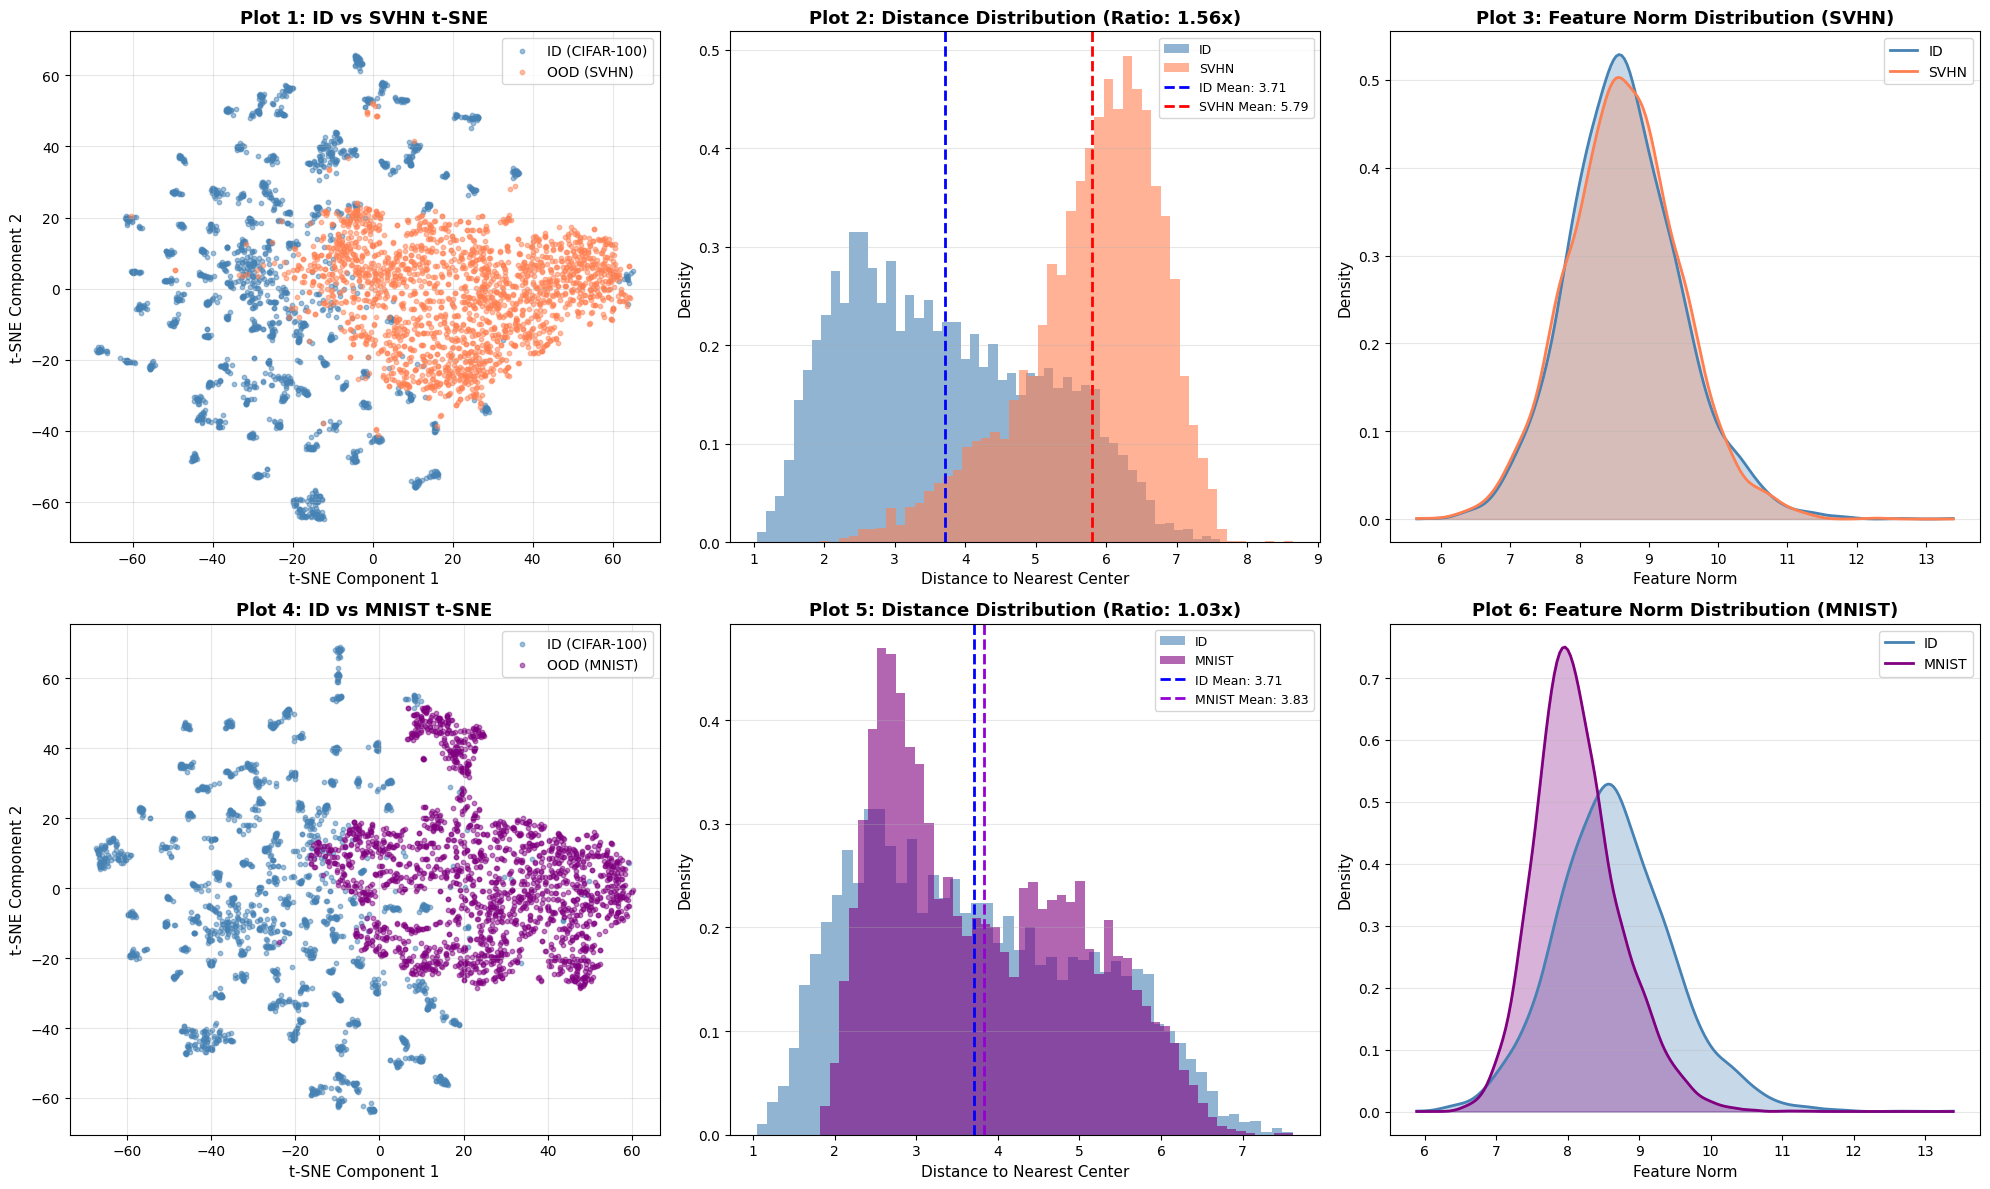

NC5 COMPARISON: SVHN vs MNIST

=== SVHN (Semantically Similar OOD) ===
ID mean distance: 3.7112
SVHN mean distance: 5.7915
Distance ratio: 1.56x
Assessment: [Partial NC5]

=== MNIST (Semantically Different OOD) ===
ID mean distance: 3.7112
MNIST mean distance: 3.8275
Distance ratio: 1.03x
Assessment: [No NC5]

=== Comparative Analysis ===
Ratio difference: MNIST is 0.66x more separated than SVHN


In [50]:
# NC5 Dual OOD Comparison Visualization

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# ============ Row 1: SVHN (Weak NC5) ============

# Plot 1: t-SNE for ID vs SVHN
print("Computing t-SNE for ID vs SVHN...")
combined_svhn = np.vstack([id_features[:2000], svhn_features[:2000]])
combined_labels_svhn = np.concatenate([np.zeros(2000), np.ones(2000)])

tsne_svhn = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d_svhn = tsne_svhn.fit_transform(combined_svhn)

id_2d_svhn = features_2d_svhn[combined_labels_svhn == 0]
ood_2d_svhn = features_2d_svhn[combined_labels_svhn == 1]

axes[0, 0].scatter(id_2d_svhn[:, 0], id_2d_svhn[:, 1], c='steelblue', s=10, alpha=0.5, label='ID (CIFAR-100)')
axes[0, 0].scatter(ood_2d_svhn[:, 0], ood_2d_svhn[:, 1], c='coral', s=10, alpha=0.5, label='OOD (SVHN)')
axes[0, 0].set_xlabel('t-SNE Component 1', fontsize=11)
axes[0, 0].set_ylabel('t-SNE Component 2', fontsize=11)
axes[0, 0].set_title('Plot 1: ID vs SVHN t-SNE', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Distance distribution for SVHN
axes[0, 1].hist(id_distances, bins=50, alpha=0.6, color='steelblue', label='ID', density=True)
axes[0, 1].hist(svhn_distances, bins=50, alpha=0.6, color='coral', label='SVHN', density=True)
axes[0, 1].axvline(np.mean(id_distances), color='blue', linestyle='--', linewidth=2,
                   label=f'ID Mean: {np.mean(id_distances):.2f}')
axes[0, 1].axvline(np.mean(svhn_distances), color='red', linestyle='--', linewidth=2,
                   label=f'SVHN Mean: {np.mean(svhn_distances):.2f}')
axes[0, 1].set_xlabel('Distance to Nearest Center', fontsize=11)
axes[0, 1].set_ylabel('Density', fontsize=11)
axes[0, 1].set_title(f'Plot 2: Distance Distribution (Ratio: {np.mean(svhn_distances)/np.mean(id_distances):.2f}x)', 
                     fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Feature norm distribution for SVHN
from scipy.stats import gaussian_kde

id_norms = np.linalg.norm(id_features, axis=1)
svhn_norms = np.linalg.norm(svhn_features, axis=1)

id_kde = gaussian_kde(id_norms)
svhn_kde = gaussian_kde(svhn_norms)

x_range_svhn = np.linspace(min(id_norms.min(), svhn_norms.min()),
                           max(id_norms.max(), svhn_norms.max()), 200)

axes[0, 2].plot(x_range_svhn, id_kde(x_range_svhn), color='steelblue', linewidth=2, label='ID')
axes[0, 2].plot(x_range_svhn, svhn_kde(x_range_svhn), color='coral', linewidth=2, label='SVHN')
axes[0, 2].fill_between(x_range_svhn, id_kde(x_range_svhn), alpha=0.3, color='steelblue')
axes[0, 2].fill_between(x_range_svhn, svhn_kde(x_range_svhn), alpha=0.3, color='coral')
axes[0, 2].set_xlabel('Feature Norm', fontsize=11)
axes[0, 2].set_ylabel('Density', fontsize=11)
axes[0, 2].set_title('Plot 3: Feature Norm Distribution (SVHN)', fontsize=13, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(axis='y', alpha=0.3)

# ============ Row 2: MNIST (NC5) ============

# Plot 4: t-SNE for ID vs MNIST
print("Computing t-SNE for ID vs MNIST...")
combined_mnist = np.vstack([id_features[:2000], mnist_features[:2000]])
combined_labels_mnist = np.concatenate([np.zeros(2000), np.ones(2000)])

tsne_mnist = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d_mnist = tsne_mnist.fit_transform(combined_mnist)

id_2d_mnist = features_2d_mnist[combined_labels_mnist == 0]
ood_2d_mnist = features_2d_mnist[combined_labels_mnist == 1]

axes[1, 0].scatter(id_2d_mnist[:, 0], id_2d_mnist[:, 1], c='steelblue', s=10, alpha=0.5, label='ID (CIFAR-100)')
axes[1, 0].scatter(ood_2d_mnist[:, 0], ood_2d_mnist[:, 1], c='purple', s=10, alpha=0.5, label='OOD (MNIST)')
axes[1, 0].set_xlabel('t-SNE Component 1', fontsize=11)
axes[1, 0].set_ylabel('t-SNE Component 2', fontsize=11)
axes[1, 0].set_title('Plot 4: ID vs MNIST t-SNE', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 5: Distance distribution for MNIST
axes[1, 1].hist(id_distances, bins=50, alpha=0.6, color='steelblue', label='ID', density=True)
axes[1, 1].hist(mnist_distances, bins=50, alpha=0.6, color='purple', label='MNIST', density=True)
axes[1, 1].axvline(np.mean(id_distances), color='blue', linestyle='--', linewidth=2,
                   label=f'ID Mean: {np.mean(id_distances):.2f}')
axes[1, 1].axvline(np.mean(mnist_distances), color='darkviolet', linestyle='--', linewidth=2,
                   label=f'MNIST Mean: {np.mean(mnist_distances):.2f}')
axes[1, 1].set_xlabel('Distance to Nearest Center', fontsize=11)
axes[1, 1].set_ylabel('Density', fontsize=11)
axes[1, 1].set_title(f'Plot 5: Distance Distribution (Ratio: {np.mean(mnist_distances)/np.mean(id_distances):.2f}x)', 
                     fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(axis='y', alpha=0.3)

# Plot 6: Feature norm distribution for MNIST
mnist_norms = np.linalg.norm(mnist_features, axis=1)

mnist_kde = gaussian_kde(mnist_norms)

x_range_mnist = np.linspace(min(id_norms.min(), mnist_norms.min()),
                            max(id_norms.max(), mnist_norms.max()), 200)

axes[1, 2].plot(x_range_mnist, id_kde(x_range_mnist), color='steelblue', linewidth=2, label='ID')
axes[1, 2].plot(x_range_mnist, mnist_kde(x_range_mnist), color='purple', linewidth=2, label='MNIST')
axes[1, 2].fill_between(x_range_mnist, id_kde(x_range_mnist), alpha=0.3, color='steelblue')
axes[1, 2].fill_between(x_range_mnist, mnist_kde(x_range_mnist), alpha=0.3, color='purple')
axes[1, 2].set_xlabel('Feature Norm', fontsize=11)
axes[1, 2].set_ylabel('Density', fontsize=11)
axes[1, 2].set_title('Plot 6: Feature Norm Distribution (MNIST)', fontsize=13, fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('NC5_comparison_svhn_vs_mnist.png', dpi=150, bbox_inches='tight')
plt.show()


print("NC5 COMPARISON: SVHN vs MNIST")

print("\n=== SVHN (Semantically Similar OOD) ===")
svhn_ratio = np.mean(svhn_distances) / np.mean(id_distances)
print(f"ID mean distance: {np.mean(id_distances):.4f}")
print(f"SVHN mean distance: {np.mean(svhn_distances):.4f}")
print(f"Distance ratio: {svhn_ratio:.2f}x")
if svhn_ratio > 3.0:
    print("Assessment: [Strong NC5]")
elif svhn_ratio > 1.5:
    print("Assessment: [Partial NC5]")
elif svhn_ratio > 1.1:
    print("Assessment: [Weak NC5]")
else:
    print("Assessment: [No NC5]")

print("\n=== MNIST (Semantically Different OOD) ===")
mnist_ratio = np.mean(mnist_distances) / np.mean(id_distances)
print(f"ID mean distance: {np.mean(id_distances):.4f}")
print(f"MNIST mean distance: {np.mean(mnist_distances):.4f}")
print(f"Distance ratio: {mnist_ratio:.2f}x")
if mnist_ratio > 3.0:
    print("Assessment: [Strong NC5]")
elif mnist_ratio > 1.5:
    print("Assessment: [Partial NC5]")
elif mnist_ratio > 1.1:
    print("Assessment: [Weak NC5]")
else:
    print("Assessment: [No NC5]")

print("\n=== Comparative Analysis ===")
print(f"Ratio difference: MNIST is {mnist_ratio/svhn_ratio:.2f}x more separated than SVHN")


# 5. Implementation of the NECO method (Neural Collapse Inspired OOD Detection).

$$ NECO(x)=\frac{||P~h_{\omega}(x)||}{||h_{\omega}(x)||} \\
=\frac{\sqrt{h_{\omega}(x)^\top PP^\top h_{\omega}(x)}}{\sqrt{h_{\omega}(x)^\top h_{\omega}(x)}}$$

With $h_{\omega}(x)$ the penultimate layer representation and $P$ the projection matrix on the biggest $d$-eigenvectors.

$P$ is fitted using a PCA on the in-distribution training features.

NECO is rescaled by the maximum-logit value. This has the effect of injecting class-based information.

In [51]:

class NECODetector:
    def __init__(self, model, num_classes):
        self.model = model
        self.model.eval()
        self.d = num_classes
        self.device = next(self.model.parameters()).device

        self.pca_components = None
        self.pca_mean = None

        self.features_buffer = []
        self.hook_handle = self.model.avgpool.register_forward_hook(self._hook_fn)

    def _hook_fn(self, module, input, output):
        self.features_buffer.append(output.view(output.size(0), -1))

    def get_features_and_logits(self, inputs):
        self.features_buffer.clear()
        logits = self.model(inputs)
        features = self.features_buffer[0]
        return features, logits

    # def fit(self, fit_loader):
    #     self.model.eval()
    #     all_features = []

    #     with torch.no_grad():
    #         for inputs, _ in fit_loader:
    #             inputs = inputs.to(self.device)
    #             features, _ = self.get_features_and_logits(inputs)
    #             all_features.append(features.detach().cpu().numpy())

    #     all_features = np.concatenate(all_features, axis=0)

    #     pca = PCA(n_components=self.d)
    #     pca.fit(all_features)

    #     self.pca_components = torch.from_numpy(pca.components_).float().to(self.device)  # [d, D]
    #     self.pca_mean = torch.from_numpy(pca.mean_).float().to(self.device)              # [D]

    def fit(self, fit_loader, num_classes=100, d=100):
        self.model.eval()
        all_features, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in fit_loader:
                inputs = inputs.to(self.device)
                features, _ = self.get_features_and_logits(inputs)
                all_features.append(features.detach().cpu().numpy())
                all_labels.append(labels.numpy())

        X = np.concatenate(all_features, axis=0)   # [N, D]
        y = np.concatenate(all_labels, axis=0)     # [N]

        class_means = []
        for c in range(num_classes):
            xc = X[y == c]
            class_means.append(xc.mean(axis=0))
        class_means = np.stack(class_means, axis=0)  # [C, D]

        global_mean = class_means.mean(axis=0, keepdims=True)
        M = class_means - global_mean                # centered class means

        # SVD on class-mean matrix
        _, _, Vt = np.linalg.svd(M, full_matrices=False)
        d_eff = min(d, num_classes - 1, Vt.shape[0])

        self.pca_components = torch.from_numpy(Vt[:d_eff]).float().to(self.device)  # [d, D]
        self.pca_mean = torch.from_numpy(global_mean.squeeze(0)).float().to(self.device)
        self.d = d_eff
        
    def predict_score(self, inputs, mode='geometry_only'):
        inputs = inputs.to(self.device)

        with torch.no_grad():
            h, logits = self.get_features_and_logits(inputs)
            h_centered = h - self.pca_mean.unsqueeze(0)

            h_reduced = torch.matmul(h_centered, self.pca_components.T)
            norm_Ph = torch.norm(h_reduced, p=2, dim=1)
            norm_h = torch.norm(h_centered, p=2, dim=1)
            ratio = norm_Ph / (norm_h + 1e-8)
            max_logit, _ = torch.max(logits, dim=1)
            if mode == 'geometry_only':
                return ratio
            elif mode == 'energy_only':
                return max_logit 
            elif mode == 'hybrid':
                return ratio * max_logit
        
    def clean_up(self):
        if self.hook_handle is not None:
            self.hook_handle.remove()
            self.hook_handle = None

In [52]:
neco_detector = NECODetector(model, num_classes=100)
mode = 'geometry_only'  # 'geometry_only', 'energy_only', or 'hybrid'
neco_detector.fit(train_loader_eval)
all_neco_scores = []
for inputs, _ in test_loader:
    scores = neco_detector.predict_score(inputs, mode=mode)
    all_neco_scores.append(scores.cpu())

neco_scores = torch.cat(all_neco_scores)
print(f"NECO scores: {neco_scores}")


NECO scores: tensor([0.8711, 0.9250, 0.9530,  ..., 0.8925, 0.9635, 0.9421])


/tmp/ipykernel_212303/3963978628.py:51: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--')


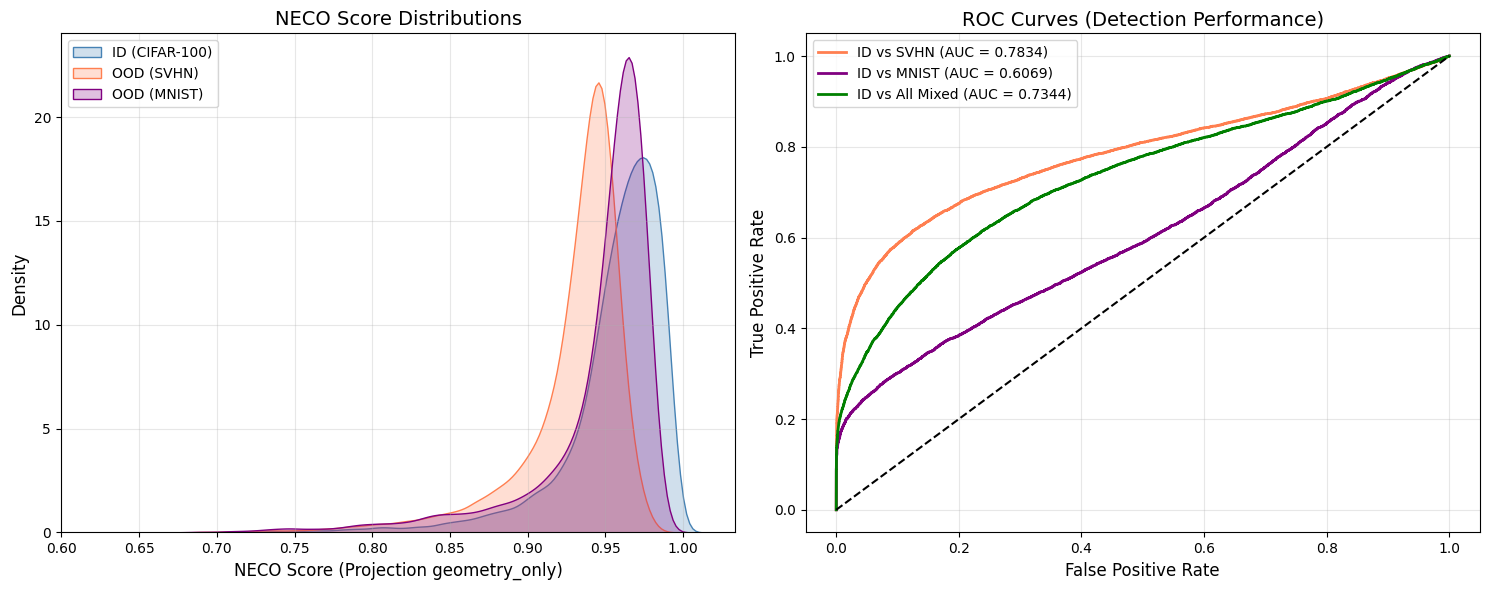


Mean ID Score: 0.9550
Mean SVHN Score: 0.9284
Mean MNIST Score: 0.9441
SVHN AUC: 0.7834
MNIST AUC: 0.6069
Average AUC: 0.6951
Pooled AUC: 0.7344

Separation Statistics:
ID vs SVHN Gap: 0.0267
ID vs MNIST Gap: 0.0109


In [53]:

def get_neco_scores(detector, loader, mode):
    scores = []
    with torch.no_grad():
        for inputs, _ in loader:
            batch_scores = detector.predict_score(inputs, mode=mode)
            scores.append(batch_scores.cpu())
    return torch.cat(scores).numpy()

if not hasattr(neco_detector, 'pca_components') or neco_detector.pca_components is None:
    print("Re-fitting NECO detector...")
    # Re-register hook if it was removed
    neco_detector.hook_handle = neco_detector.model.avgpool.register_forward_hook(neco_detector._hook_fn)
    neco_detector.fit(train_loader_eval)

id_neco_scores = get_neco_scores(neco_detector, test_loader, mode)

# OOD Scores
svhn_neco_scores = get_neco_scores(neco_detector, svhn_loader, mode)
mnist_neco_scores = get_neco_scores(neco_detector, mnist_loader, mode)

# Visualization
plt.figure(figsize=(15, 6))

# Plot 1: Score Distributions
plt.subplot(1, 2, 1)
sns.kdeplot(id_neco_scores, label='ID (CIFAR-100)', fill=True, color='steelblue')
sns.kdeplot(svhn_neco_scores, label='OOD (SVHN)', fill=True, color='coral')
sns.kdeplot(mnist_neco_scores, label='OOD (MNIST)', fill=True, color='purple')
plt.title('NECO Score Distributions', fontsize=14)
plt.xlabel(f'NECO Score (Projection {mode})', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: AUROC Curves
plt.subplot(1, 2, 2)

def plot_roc(id_scores, ood_scores, label, color):
    y_true = np.concatenate([np.ones(len(id_scores)), np.zeros(len(ood_scores))])
    y_scores = np.concatenate([id_scores, ood_scores])
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.4f})', color=color, linewidth=2)
    return auc

auc_svhn = plot_roc(id_neco_scores, svhn_neco_scores, 'ID vs SVHN', 'coral')
auc_mnist = plot_roc(id_neco_scores, mnist_neco_scores, 'ID vs MNIST', 'purple')
all_ood_scores = np.concatenate([svhn_neco_scores, mnist_neco_scores])
auc_pooled = plot_roc(id_neco_scores, all_ood_scores, 'ID vs All Mixed', 'green')

plt.plot([0, 1], [0, 1], 'k--', linestyle='--')
plt.title('ROC Curves (Detection Performance)', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMean ID Score: {np.mean(id_neco_scores):.4f}")
print(f"Mean SVHN Score: {np.mean(svhn_neco_scores):.4f}")
print(f"Mean MNIST Score: {np.mean(mnist_neco_scores):.4f}")

print(f"SVHN AUC: {auc_svhn:.4f}")
print(f"MNIST AUC: {auc_mnist:.4f}")
print(f"Average AUC: {(auc_svhn + auc_mnist) / 2:.4f}")
print(f"Pooled AUC: {auc_pooled:.4f}")

print("\nSeparation Statistics:")
print(f"ID vs SVHN Gap: {np.mean(id_neco_scores) - np.mean(svhn_neco_scores):.4f}")
print(f"ID vs MNIST Gap: {np.mean(id_neco_scores) - np.mean(mnist_neco_scores):.4f}")


Extracting NECO components for detailed analysis...


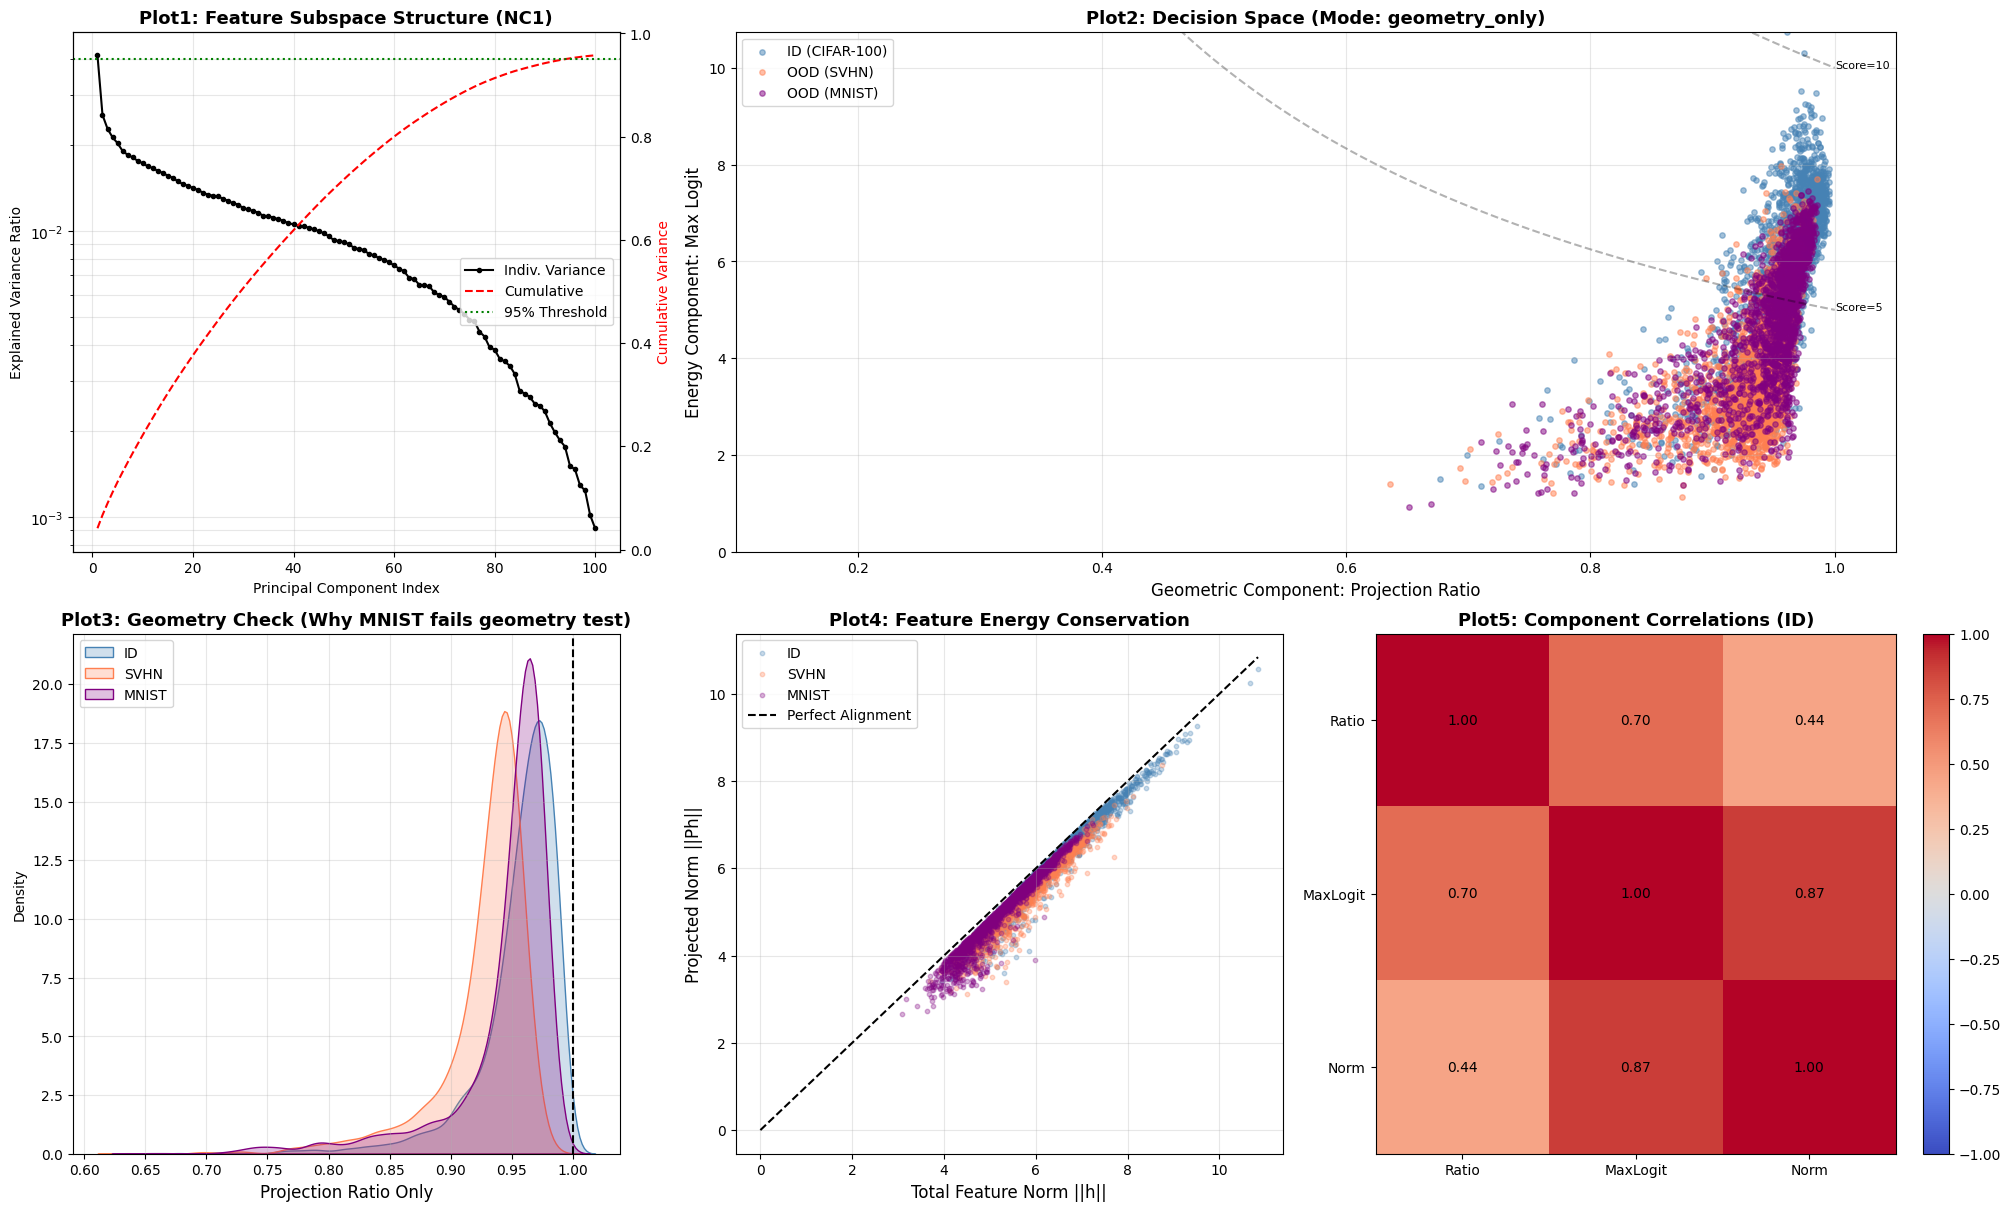


=== NECO Deep Dive Statistics ===
1. Subspace Compactness (NC1):
Top 20 components explain 37.63% of variance.
Top 99 components explain 95.74% of variance.

2. Orthogonality (NC5 check via Projection Ratio):
ID Mean Ratio:   0.9555 (Ideally close to 1.0)
SVHN Mean Ratio: 0.9274 (Lower means orthogonal to ID subspace)
MNIST Mean Ratio:0.9441
Orthogonality Gap (ID-SVHN): 0.0281

3. Contribution Analysis:
Do OOD samples fail on Geometry (Ratio) or Confidence (Logit)?
[SVHN] Logit Gap: 2.19 | Ratio Gap: 0.03
[MNIST] Logit Gap: 0.95 | Ratio Gap: 0.01

Conclusion:
Weak NC5 effect for SVHN: OOD samples lie in similar subspace as ID.


In [54]:
n_components = 100
def extract_neco_components(detector, loader, max_samples=2000):
    detector.model.eval()
    ratios = []
    max_logits = []
    total_norms = []
    projection_norms = []
    
    samples_count = 0
    with torch.no_grad():
        for inputs, _ in loader:
            if samples_count >= max_samples:
                break
            if torch.cuda.is_available():
                inputs = inputs.cuda()
            
            # Use detector internals
            h, logits = detector.get_features_and_logits(inputs)
            
            # Re-compute components
            h_centered = h - detector.pca_mean.unsqueeze(0)
            h_reduced = torch.matmul(h_centered, detector.pca_components.T)
            norm_Ph = torch.norm(h_reduced, p=2, dim=1) # Norm in Principal Subspace
            norm_h = torch.norm(h_centered, p=2, dim=1)          # Total Norm
            
            ratio = norm_Ph / (norm_h + 1e-8)
            logit_val, _ = torch.max(logits, dim=1)
            
            ratios.append(ratio.cpu().numpy())
            max_logits.append(logit_val.cpu().numpy())
            total_norms.append(norm_h.cpu().numpy())
            projection_norms.append(norm_Ph.cpu().numpy())
            
            samples_count += inputs.size(0)
            
    return (np.concatenate(ratios), np.concatenate(max_logits), 
            np.concatenate(total_norms), np.concatenate(projection_norms))

print("Extracting NECO components for detailed analysis...")
id_ratios, id_logits, id_tot_norms, id_proj_norms = extract_neco_components(neco_detector, test_loader)
svhn_ratios, svhn_logits, svhn_tot_norms, svhn_proj_norms = extract_neco_components(neco_detector, svhn_loader)
mnist_ratios, mnist_logits, mnist_tot_norms, mnist_proj_norms = extract_neco_components(neco_detector, mnist_loader)

# PCA Spectrum Analysis (Validating the Subspace Assumption - NC1)
from sklearn.decomposition import PCA
pca_check = PCA(n_components) # Check top N components
flat_id_features = []
with torch.no_grad():
    for inputs, _ in test_loader:
        if torch.cuda.is_available(): inputs = inputs.cuda()
        f, _ = neco_detector.get_features_and_logits(inputs)
        flat_id_features.append(f.cpu().numpy())
        if len(flat_id_features) * 128 > 2000: break
flat_id_features = np.concatenate(flat_id_features, axis=0)

pca_check.fit(flat_id_features)
explained_variance = pca_check.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
fig = plt.figure(figsize=(20, 12), constrained_layout=True)
spec = fig.add_gridspec(2, 3)

# Plot 1: PCA
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(range(1, n_components+1), explained_variance, 'o-', markersize=3, color='black', label='Indiv. Variance')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_xlabel('Principal Component Index')
ax1.set_title('Plot1: Feature Subspace Structure (NC1)', fontsize=13, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, which="both", ls="-", alpha=0.3)
# Secondary axis for cumulative
ax1b = ax1.twinx()
ax1b.plot(range(1, n_components+1), cumulative_variance, 'r--', label='Cumulative')
ax1b.set_ylabel('Cumulative Variance', color='red')
ax1b.axhline(0.95, color='green', linestyle=':', label='95% Threshold')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center right')

# Plot 2: 2D Scatter
ax2 = fig.add_subplot(spec[0, 1:]) # Span 2 columns
ax2.scatter(id_ratios, id_logits, c='steelblue', s=15, alpha=0.5, label='ID (CIFAR-100)')
ax2.scatter(svhn_ratios, svhn_logits, c='coral', s=15, alpha=0.5, label='OOD (SVHN)')
ax2.scatter(mnist_ratios, mnist_logits, c='purple', s=15, alpha=0.5, label='OOD (MNIST)')
x = np.linspace(0.1, 1.05, 200)
thresholds = [2.0, 4.0, 6.0] 
if mode == 'hybrid':
    for th in thresholds:
        y = th / x
        ax2.plot(x, y, 'k--', alpha=0.4, linewidth=1)
        ax2.text(0.9, th/0.9, f'Score={th}', fontsize=9, rotation=-15)
    ax2.set_title(f'Plot2: Hybrid Decision Space (Score = Ratio * Logit)', fontsize=13, fontweight='bold')
else:
    ax2.set_title(f'Plot2: Decision Space (Mode: {mode})', fontsize=13, fontweight='bold')

ax2.set_xlabel('Geometric Component: Projection Ratio', fontsize=12)
ax2.set_ylabel('Energy Component: Max Logit', fontsize=12)
ax2.set_ylim(0, max(id_logits.max(), 10))
ax2.set_xlim(0.1, 1.05)
ax2.legend()
ax2.grid(alpha=0.3)

x_range = np.linspace(0.2, 1.0, 100)
for threshold in [5, 10]:
    y_vals = threshold / x_range
    ax2.plot(x_range, y_vals, 'k--', alpha=0.3)
    ax2.text(x_range[-1], y_vals[-1], f'Score={threshold}', fontsize=8)

# Plot 3: Projection Ratio Distribution
ax3 = fig.add_subplot(spec[1, 0])
sns.kdeplot(id_ratios, ax=ax3, fill=True, color='steelblue', label='ID')
sns.kdeplot(svhn_ratios, ax=ax3, fill=True, color='coral', label='SVHN')
sns.kdeplot(mnist_ratios, ax=ax3, fill=True, color='purple', label='MNIST')
ax3.set_xlabel('Projection Ratio Only', fontsize=12)
ax3.set_title('Plot3: Geometry Check (Why MNIST fails geometry test)', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.axvline(1.0, color='k', linestyle='--')

# Plot 4: Norm Comparison
ax4 = fig.add_subplot(spec[1, 1])
ax4.scatter(id_tot_norms, id_proj_norms, c='steelblue', s=10, alpha=0.3, label='ID')
ax4.scatter(svhn_tot_norms, svhn_proj_norms, c='coral', s=10, alpha=0.3, label='SVHN')
ax4.scatter(mnist_tot_norms, mnist_proj_norms, c='purple', s=10, alpha=0.3, label='MNIST')
# y=x line
lims = [0, max(id_tot_norms.max(), mnist_tot_norms.max())]
ax4.plot(lims, lims, 'k--', label='Perfect Alignment')
ax4.set_xlabel('Total Feature Norm ||h||', fontsize=12)
ax4.set_ylabel('Projected Norm ||Ph||', fontsize=12)
ax4.set_title('Plot4: Feature Energy Conservation', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# Plot 5: Correlation Matrix of Components
ax5 = fig.add_subplot(spec[1, 2])
data_stack = np.stack([id_ratios, id_logits, id_tot_norms], axis=1)
corr_mat = np.corrcoef(data_stack.T)
im = ax5.imshow(corr_mat, cmap='coolwarm', vmin=-1, vmax=1)
ax5.set_xticks([0, 1, 2])
ax5.set_yticks([0, 1, 2])
ax5.set_xticklabels(['Ratio', 'MaxLogit', 'Norm'])
ax5.set_yticklabels(['Ratio', 'MaxLogit', 'Norm'])
for i in range(3):
    for j in range(3):
        ax5.text(j, i, f"{corr_mat[i, j]:.2f}", ha="center", va="center", color="black")
ax5.set_title('Plot5: Component Correlations (ID)', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax5)

plt.savefig('NECO_detailed_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Textual Analysis
print("\n=== NECO Deep Dive Statistics ===")
print("1. Subspace Compactness (NC1):")
print(f"Top 20 components explain {cumulative_variance[19]*100:.2f}% of variance.")
print(f"Top {neco_detector.d} components explain {cumulative_variance[-1]*100:.2f}% of variance.")

print("\n2. Orthogonality (NC5 check via Projection Ratio):")
print(f"ID Mean Ratio:   {np.mean(id_ratios):.4f} (Ideally close to 1.0)")
print(f"SVHN Mean Ratio: {np.mean(svhn_ratios):.4f} (Lower means orthogonal to ID subspace)")
print(f"MNIST Mean Ratio:{np.mean(mnist_ratios):.4f}")
print(f"Orthogonality Gap (ID-SVHN): {np.mean(id_ratios) - np.mean(svhn_ratios):.4f}")

print("\n3. Contribution Analysis:")
print("Do OOD samples fail on Geometry (Ratio) or Confidence (Logit)?")
id_svhn_logit_gap = np.mean(id_logits) - np.mean(svhn_logits)
id_svhn_ratio_gap = np.mean(id_ratios) - np.mean(svhn_ratios)
print(f"[SVHN] Logit Gap: {id_svhn_logit_gap:.2f} | Ratio Gap: {id_svhn_ratio_gap:.2f}")

id_mnist_logit_gap = np.mean(id_logits) - np.mean(mnist_logits)
id_mnist_ratio_gap = np.mean(id_ratios) - np.mean(mnist_ratios)
print(f"[MNIST] Logit Gap: {id_mnist_logit_gap:.2f} | Ratio Gap: {id_mnist_ratio_gap:.2f}")

print("\nConclusion:")
if np.mean(svhn_ratios) < 0.8:
    print("Significant NC5 effect observed: SVHN is orthogonal to ID subspace.")
else:
    print("Weak NC5 effect for SVHN: OOD samples lie in similar subspace as ID.")


# Clean up finally
if hasattr(neco_detector, 'clean_up'):
    neco_detector.clean_up()

# 7. Comparison across methods
We now compare the most suspicious samples to be OOD identified by each method. Overlap suggests a robust detection of an outlier or hard sample. We select the Top-K samples that appear most "OOD-like" according to each metric.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

K = 20 # number of samples to inspect
M = 3 # minimum number of methods that agree for consensus
idx_msp = torch.argsort(msp_scores, descending=True)[:K]
idx_logit = torch.argsort(max_logit_scores, descending=False)[:K]
idx_energy = torch.argsort(energy_scores, descending=False)[:K]
idx_maha = torch.argsort(mahalanobis_scores, descending=False)[:K]
idx_vim = torch.argsort(vim_scores, descending=True)[:K] 
idx_neco = torch.argsort(neco_scores, descending=False)[:K]

# Compare Overlaps
method_indices = {
    "MSP": idx_msp,
    "MaxLogit": idx_logit,
    "Energy": idx_energy,
    "Mahalanobis": idx_maha,
    "ViM": idx_vim,
    "NECO": idx_neco
}

print(f"Top {K} suspicious OOD samples for each method:")
for name, idxs in method_indices.items():
    print(f"{name}: {idxs}")

# Intersection
all_sets = [set(v) for v in method_indices.values()]
intersection = set.intersection(*all_sets)
print(f"\nIntersection (detected by ALL methods): {intersection if intersection else 'None'}")

# Consensus (detected by at least N methods)
all_indices_flat = np.concatenate(list(method_indices.values()))
counts = Counter(all_indices_flat)

print(f"\nMost suspicious samples that are detected by >= {M} methods:")
sorted_consensus = sorted(counts.items(), key=lambda x: x[1], reverse=True)
consensus_indices = []
for idx, count in sorted_consensus:
    if count >= M:
        print(f"Sample ID {idx}: detected by {count} methods")
        consensus_indices.append(idx)

Top 20 suspicious OOD samples for each method:
MSP: tensor([1295, 6937, 9358, 8036, 9701, 4011, 1152, 2281, 2280, 3427, 8507, 7579,
        6991, 6868, 9850, 7015,  605,  772, 7566, 5573])
MaxLogit: tensor([4832, 8095, 6061,  854, 9103, 8013, 5068,  500, 7114, 9088, 6401, 7379,
        1889, 8214, 8820, 8442, 7553, 9229,  936, 1790])
Energy: tensor([9103, 4832, 4761, 5068,  854, 8013, 6695, 7517, 7405, 5382, 4332, 8784,
        1591, 3647, 6061,  500, 8894, 7324,  627, 1889])
Mahalanobis: tensor([7610, 4458, 7116, 8750, 3771, 4969, 9997, 6937,   86, 1440, 9385, 5573,
        6830, 2485, 7933, 6616, 3131, 1869, 9852, 3827])
ViM: tensor([7610, 4458, 8750, 3771, 9997, 9385,   86, 7116, 6616, 1869, 4969, 2845,
        4143, 4156, 4353, 6285, 9845, 8505, 6830, 3827])
NECO: tensor([4832, 1889, 7405, 3647,  527, 6695,  854, 9495, 8013,  627, 9742, 5382,
        9103, 9088, 9229, 8214, 8766, 9126, 4684, 2588])

Intersection (detected by ALL methods): None

Most suspicious samples that are dete